In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
import seaborn as sns
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

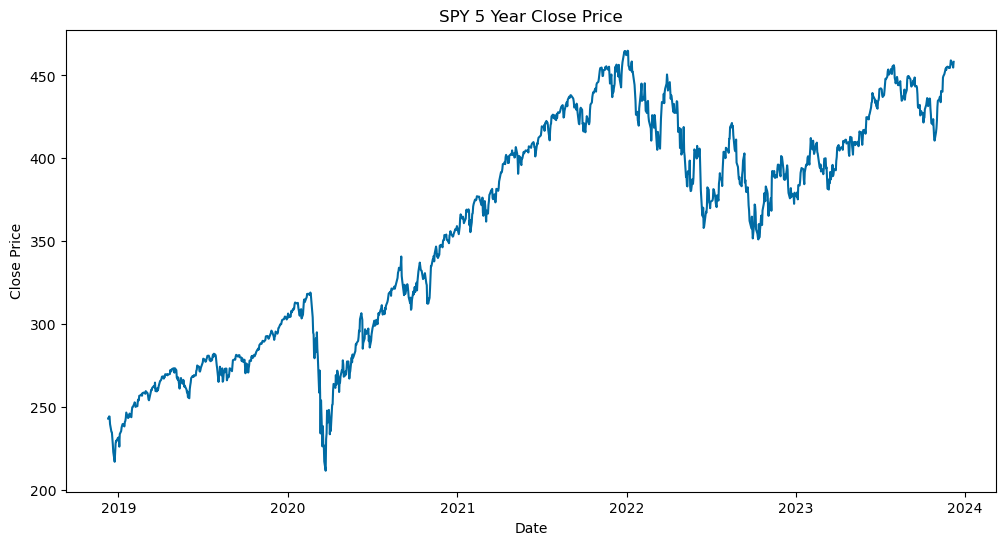

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

In [5]:
close

Date
2018-12-10 00:00:00-05:00    242.926071
2018-12-11 00:00:00-05:00    242.981308
2018-12-12 00:00:00-05:00    244.204773
2018-12-13 00:00:00-05:00    244.122009
2018-12-14 00:00:00-05:00    239.614319
                                ...    
2023-12-01 00:00:00-05:00    459.100006
2023-12-04 00:00:00-05:00    456.690002
2023-12-05 00:00:00-05:00    456.600006
2023-12-06 00:00:00-05:00    454.760010
2023-12-07 00:00:00-05:00    458.230011
Name: Close, Length: 1258, dtype: float64

## Check stationarity

### Split Price into halves for statistical analysis

In [6]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=303.628889, mean2=416.065248, mean_percent_diff=37.030850
variance1=2182.002489, variance2=706.058791, var_percent_diff=-67.641706


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [7]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.612388
p-value: 0.476722
Critical Values:
{'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [8]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.687955293916086, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.69
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

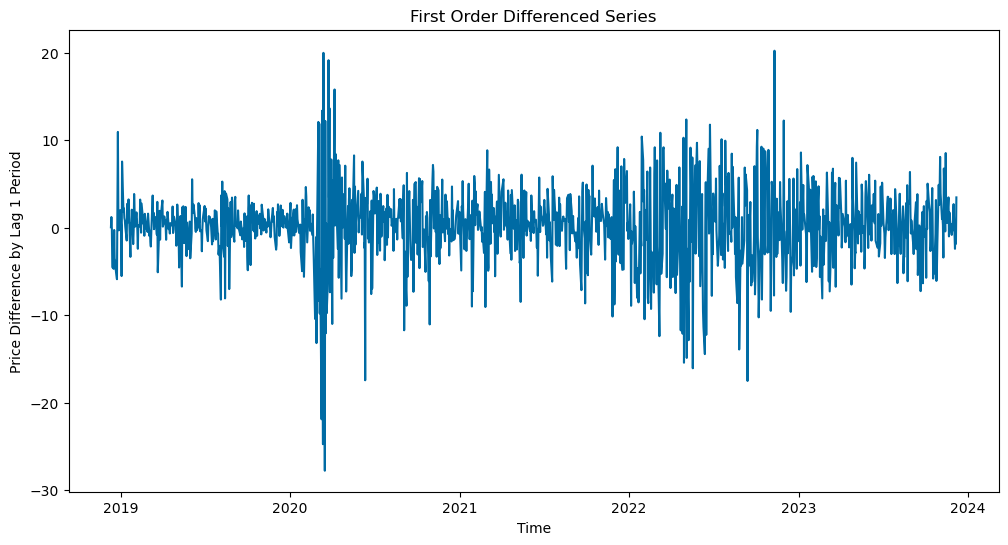

In [9]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14)
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [10]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -11.052823
p-value: 0.000000
Critical Values:
{'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [11]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [12]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [13]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: ADS506 - Module 1 and https://www.statsmodels.org/stable/tsa.html

In [14]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3052.3527115854754
BIC = 3062.1801862867947
Time Series Evaluation Metrics
MSE = 1539.0769745834953
MAE = 32.88269696616316
RMSE = 39.231071545185905
MAPE = 0.07578424569649869
r2 = -1.7872376506579326



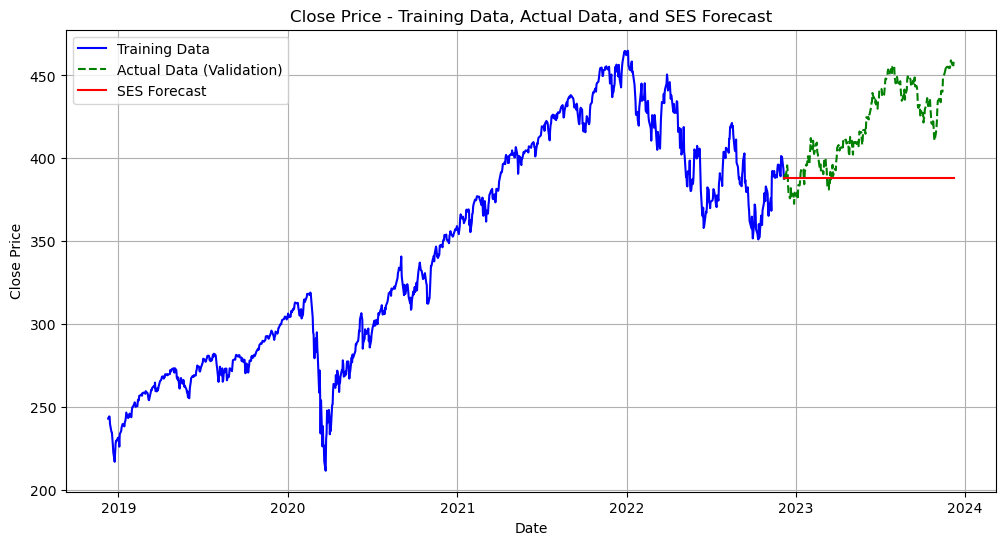

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

Simple Exponential Smoothing RMSE is 34.56% and it is higher to our success rate criteria. The forecast also doesn't include trend, seasonality and noise

In [16]:
# #impute to decompose
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

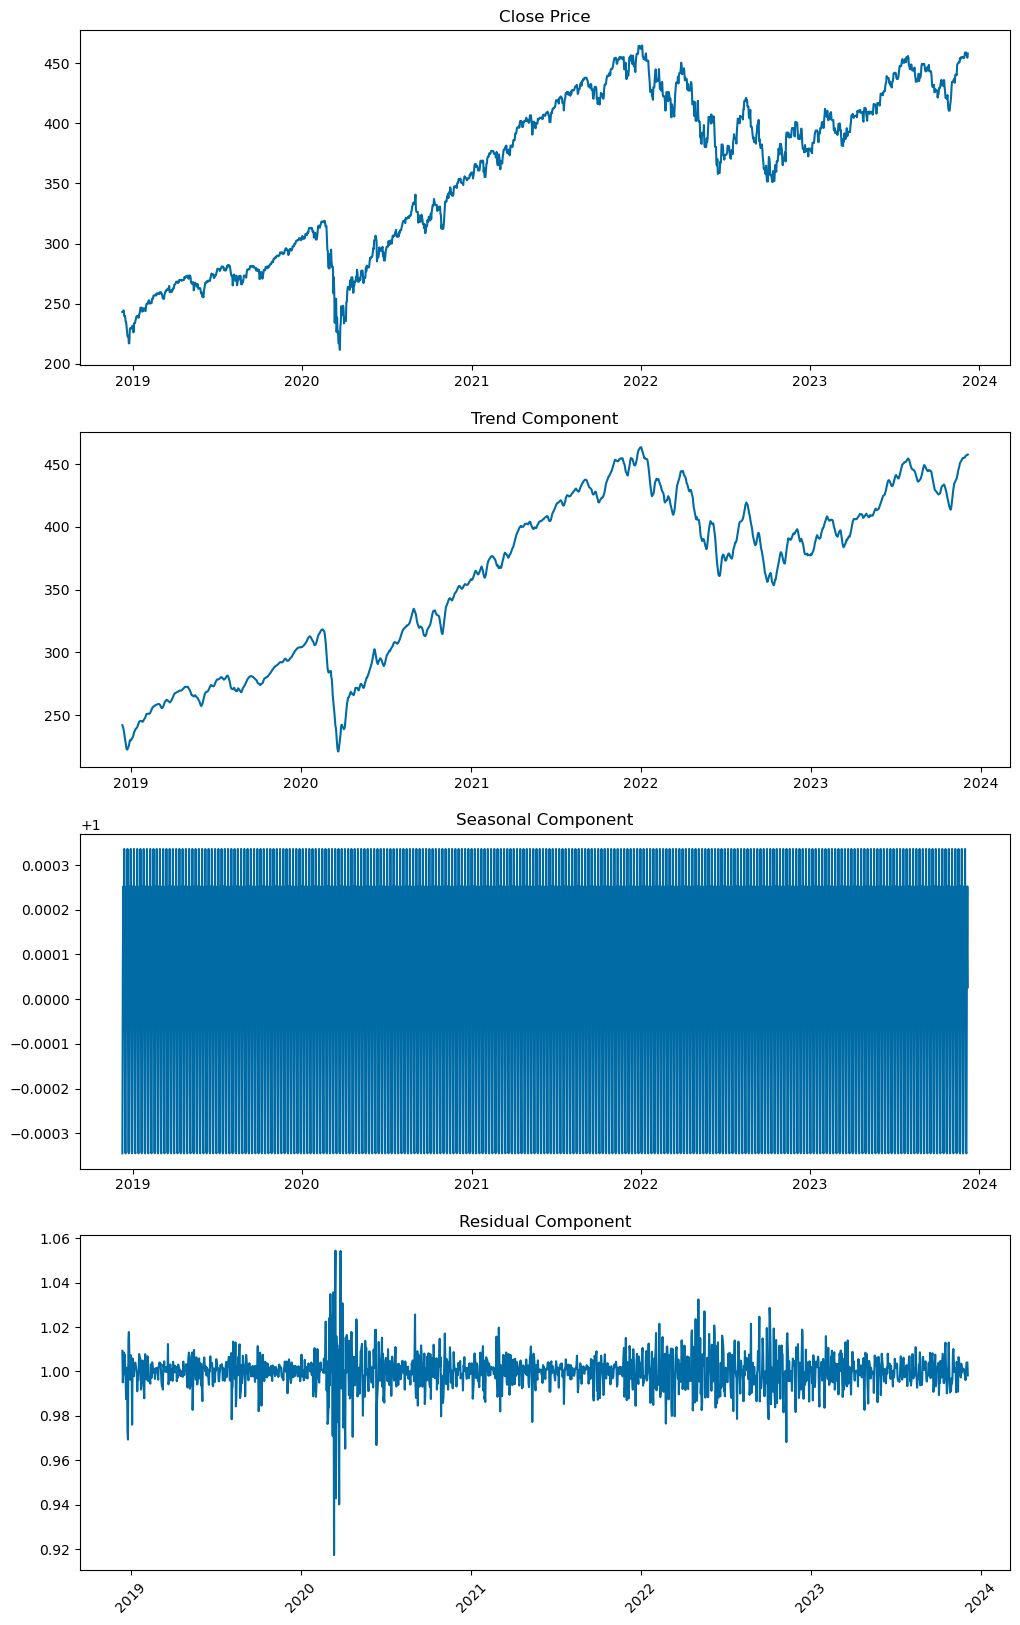

In [17]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

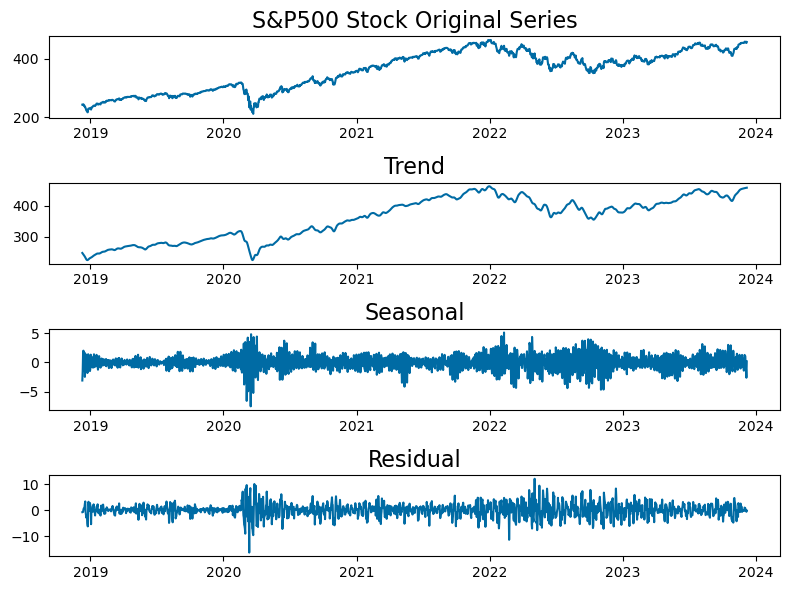

In [18]:
stl_close = STL(close)
stl_close_f = stl_close.fit()


# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(close)
plt.title('S&P500 Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(stl_close_f.trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(stl_close_f.seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(stl_close_f.resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

Seasonal-Trend decomposition using LOESS (STL) shows a positive trend on SPY and seasonal around quarterly basis

### Anomaly Detection from STL Decomposition

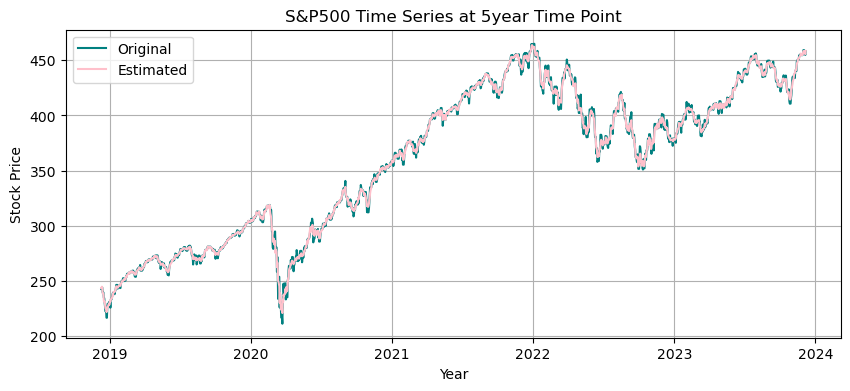

In [19]:
estimated0 = stl_close_f.trend + stl_close_f.seasonal
plt.figure(figsize=(10,4))
plt.plot(close, label='Original', color = 'teal')
plt.plot(estimated0, label ='Estimated', color = 'pink')


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('S&P500 Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Taking residuals and detecting anomaly at 3std. dev:

resid_mu0 = stl_close_f.resid.mean()
resid_dev0 = stl_close_f.resid.std()

lower0 = resid_mu0 - 3*resid_dev0
upper0 = resid_mu0 + 3*resid_dev0

Text(0.5, 1.0, 'S&P500 at 5year Time Point')

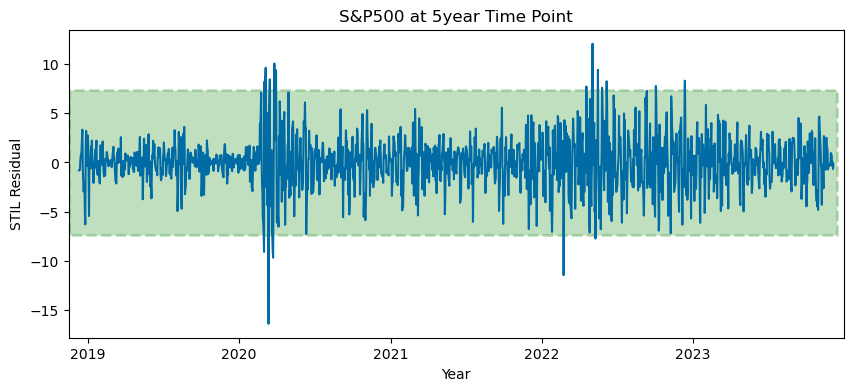

In [21]:
# Plot residual threshold:

plt.figure(figsize=(10,4))
plt.plot(stl_close_f.resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower0, upper0, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,11,15), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('S&P500 at 5year Time Point')

In [22]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies0 = close[(stl_close_f.resid < lower0) | (stl_close_f.resid > upper0)]
anomalies0 = pd.DataFrame(anomalies0)

Text(0.5, 1.0, 'S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

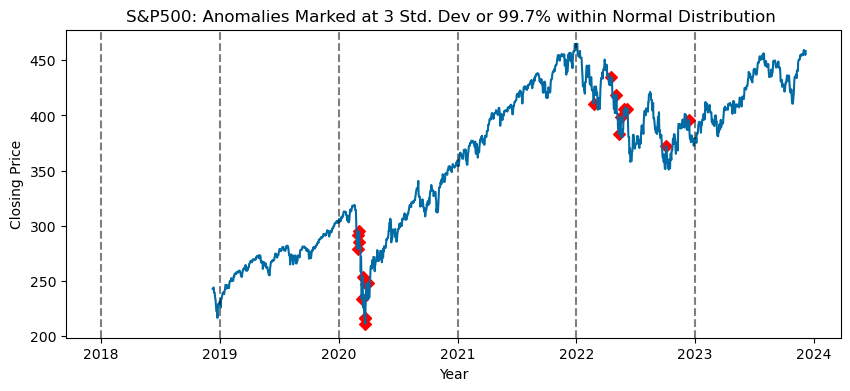

In [23]:
# Plot identified residual anomalies:

plt.figure(figsize=(10,4))
plt.plot(close)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies0.index, anomalies0.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

In [24]:
# Anomalies identified outside 3std dev of residuals:

anomalies0.head()

Close
Date                                 
2020-03-01 00:00:00-05:00  279.321106
2020-03-02 00:00:00-05:00  291.417542
2020-03-04 00:00:00-05:00  294.971954
2020-03-05 00:00:00-05:00  285.166565
2020-03-12 00:00:00-04:00  233.924103

### Gather parameters from decomposition

In [25]:
stl_close.config, stl_close.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

## TO DO
### 1. Fit models to TREND and SEASON components
### 2. Make predictions with steps=len(close_valid) for each
### 3. Add these predictions to ARIMA predictions for FINAL prediction (sum of all components)

In [26]:
# Trend model for trend time series 'trend' from Blk 16 above
# <code here>

# Season model for seasonal time series 'seasonal' from Blk 16 above
# <code here>

# Make predictions for each to be added to the ARIMA residual predictions
# <code here>

### Autocorrelation - Raw Values
#### References: https://www.statsmodels.org/devel/graphics.html#time-series-plots

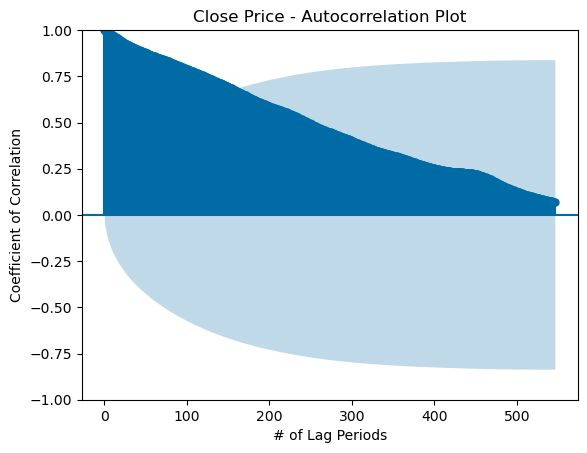

In [27]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

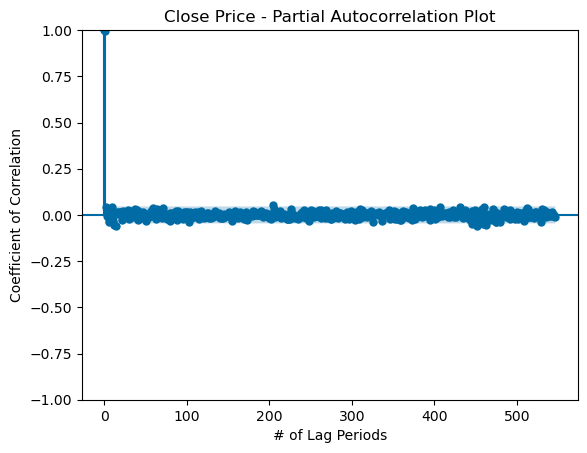

In [28]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

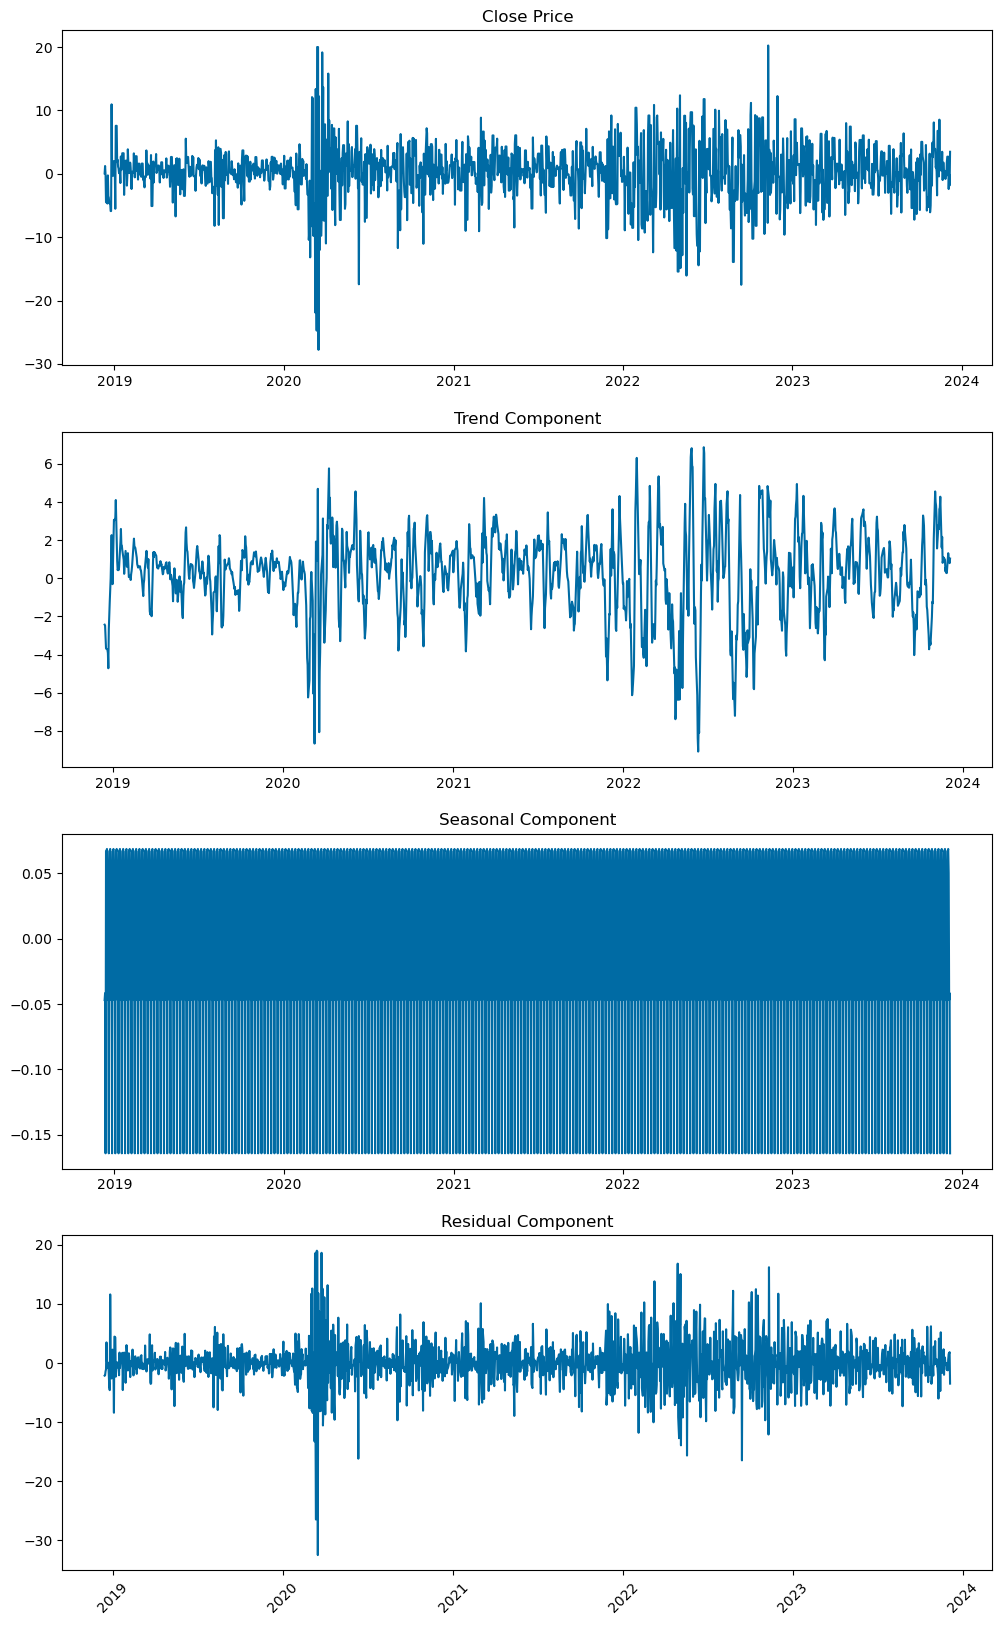

In [29]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

### Decompose using STL

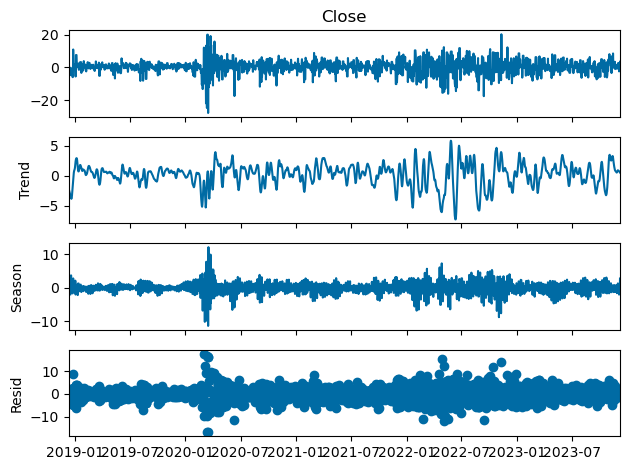

In [30]:
stl = STL(ts_lag_1)
stl_plot = stl.fit().plot()

In [31]:
stl.config, stl.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29 and 

### ACF on lag_1 period

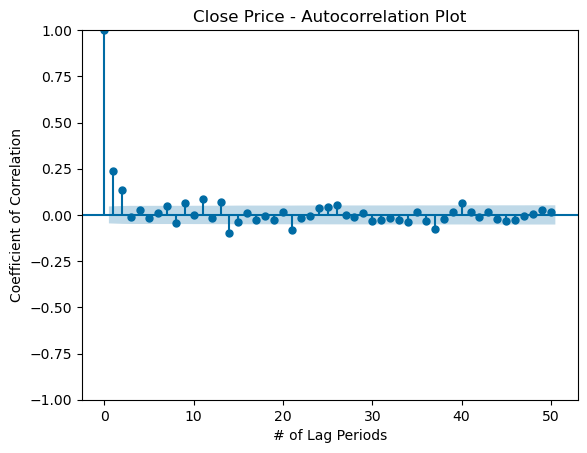

In [32]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we see a positive pattern in the quarterly basis. We may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

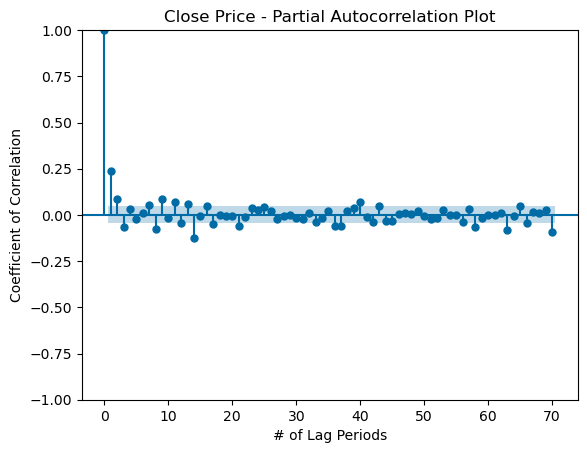

In [33]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

#### Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube].
#### https://www.youtube.com/watch?v=McEN54l3EPU
#### Finding AR_orders code would take a small of time

In [34]:
ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')


AIC for AR(1): 10431.445453111279
BIC for AR(1): 10447.968523344738


AIC for AR(2): 10419.711644696581
BIC for AR(2): 10441.74240500786


AIC for AR(3): 10413.90079820883
BIC for AR(3): 10441.43924859793


AIC for AR(8): 10405.308583463575
BIC for AR(8): 10460.385484241773


AIC for AR(9): 10393.753048197113
BIC for AR(9): 10454.337639053132


AIC for AR(11): 10388.772032126622
BIC for AR(11): 10460.372003138282


AIC for AR(14): 10357.453529566883
BIC for AR(14): 10445.576570812002


AIC for AR(21): 10356.615601734227
BIC for AR(21): 10483.292473524085




### The lower AIC and BIC is the better model selection; AR(14) has the lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

#### Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube].
#### https://www.youtube.com/watch?v=McEN54l3EPU
#### Finding AR_orders code (q) would take some time

In [35]:
#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')


AIC for MA(0): 10464.47440573344
BIC for MA(0): 10547.089756900737


AIC for MA(1): 10357.453529566883
BIC for MA(1): 10445.576570812002


AIC for MA(2): 10387.787761893393
BIC for MA(2): 10481.418493216332


AIC for MA(11): 10349.881200089825
BIC for MA(11): 10493.081142113142


AIC for MA(13): 10345.428349085869
BIC for MA(13): 10499.643671264826


AIC for MA(14): 10350.215202020274
BIC for MA(14): 10509.938214277052


AIC for MA(21): 10354.180790175456
BIC for MA(21): 10552.457632976973


AIC for MA(37): 10341.48693319786
BIC for MA(37): 10627.886817244496


AIC for MA(40): 10345.018844600527
BIC for MA(40): 10647.941798880622




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [36]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10357.453529566883
BIC = 10445.576570812002
Time Series Evaluation Metrics
MSE = 176545.27515705882
MAE = 419.51505322753746
RMSE = 420.1729110224252
MAPE = 0.9994533913248156
r2 = -318.71996598590124



### Result: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [37]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [38]:
#close_train.index

In [39]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [40]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3556.675581187151
BIC = 3591.0717426417687
Time Series Evaluation Metrics
MSE = 1148.5455341228549
MAE = 28.00667225226273
RMSE = 33.89019820129199
MAPE = 0.06460857588651578
r2 = -1.0799930146889332

Results for Seasonal Period 3
AIC = 3902.6020177658384
BIC = 3941.911916571116
Time Series Evaluation Metrics
MSE = 275.2564759005492
MAE = 14.25435336874106
RMSE = 16.59085518894518
MAPE = 0.03403529775482453
r2 = 0.5015160216888765

Results for Seasonal Period 8
AIC = 4437.79278143981
BIC = 4501.671366998386
Time Series Evaluation Metrics
MSE = 938.3306490742501
MAE = 28.119626809019817
RMSE = 30.63218322409048
MAPE = 0.06800242907390276
r2 = -0.6992980578985089

Results for Seasonal Period 9
AIC = 4451.342429961051
BIC = 4520.134752870286
Time Series Evaluation Metrics
MSE = 1750.5455950195694
MAE = 39.77266039932815
RMSE = 41.839521926278856
MAPE = 0.09534909709562232
r2 = -2.1702030971857935

Results for Seasonal Period 11
AIC = 4533.680411460517
B

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [41]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3916.991848611712
BIC = 3951.38801006633
Time Series Evaluation Metrics
MSE = 707.1398937222724
MAE = 22.506800545810975
RMSE = 26.592102092957457
MAPE = 0.05384707025750996
r2 = -0.2806162190804977

Results for Seasonal mul
AIC = 3918.2934776071593
BIC = 3952.689639061777
Time Series Evaluation Metrics
MSE = 826.5883382341756
MAE = 24.571332139084475
RMSE = 28.750449357082676
MAPE = 0.05866119139875846
r2 = -0.496934965546183

Results for Seasonal additive
AIC = 3916.991848611712
BIC = 3951.38801006633
Time Series Evaluation Metrics
MSE = 707.1398937222724
MAE = 22.506800545810975
RMSE = 26.592102092957457
MAPE = 0.05384707025750996
r2 = -0.2806162190804977

Results for Seasonal multiplicative
AIC = 3918.2934776071593
BIC = 3952.689639061777
Time Series Evaluation Metrics
MSE = 826.5883382341756
MAE = 24.571332139084475
RMSE = 28.750449357082676
MAPE = 0.05866119139875846
r2 = -0.496934965546183

Results for Seasonal None
AIC = 4663.993462190891
BIC = 46

### Validation statistics suggest additive seasonality is optimal where it has the lowest RMSE

### Searching for ideal trend parameter

In [42]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train,
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     #damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3926.1825877154283
BIC = 3960.578749170046
Time Series Evaluation Metrics
MSE = 393.18151171834944
MAE = 16.518900499607835
RMSE = 19.828805100619388
MAPE = 0.039929703601345165
r2 = 0.2879561379309463

Results for Trend mul
AIC = 3916.9925855616093
BIC = 3951.388747016227
Time Series Evaluation Metrics
MSE = 707.1448452832925
MAE = 22.506885876613445
RMSE = 26.59219519489304
MAPE = 0.053847269310266586
r2 = -0.28062518625857424

Results for Trend additive
AIC = 3926.1825877154283
BIC = 3960.578749170046
Time Series Evaluation Metrics
MSE = 393.18151171834944
MAE = 16.518900499607835
RMSE = 19.828805100619388
MAPE = 0.039929703601345165
r2 = 0.2879561379309463

Results for Trend multiplicative
AIC = 3916.9925855616093
BIC = 3951.388747016227
Time Series Evaluation Metrics
MSE = 707.1448452832925
MAE = 22.506885876613445
RMSE = 26.59219519489304
MAPE = 0.053847269310266586
r2 = -0.28062518625857424

Results for Trend None
AIC = 3881.722531501434
BIC = 3906.29

### Validation statistics suggest multiplicative trend is optimal. Upon further investigation, the trend parameter varies on which value is optimal as new data is rolled into the dataframe. Further exploration is needed to determine which trend parameter value is optimal for the greatest likelihood on a rolling 3-day basis.

### Searching for ideal aes_param_damped_trend parameter

In [43]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3905.2071672569714
BIC = 3944.517066062249
Time Series Evaluation Metrics
MSE = 314.2475123700285
MAE = 14.993864886488842
RMSE = 17.727027736482743
MAPE = 0.03549166702510425
r2 = 0.43090403367228003

Results for Damped Trend False
AIC = 3916.9922761661282
BIC = 3951.388437620746
Time Series Evaluation Metrics
MSE = 707.1411377536863
MAE = 22.506822157856423
RMSE = 26.592125483941413
MAPE = 0.05384712091048449
r2 = -0.2806184719965328



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [44]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train,
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3,
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1,
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3907.9594614113907
BIC = 3942.3556228660086
Time Series Evaluation Metrics
MSE = 415.81920520920954
MAE = 17.033235779972934
RMSE = 20.391645475763095
MAPE = 0.04113905455528904
r2 = 0.24695972731356675

Results for Initialization Method estimated
AIC = 3902.741294266123
BIC = 3937.137455720741
Time Series Evaluation Metrics
MSE = 420.7763448649716
MAE = 17.145485167698244
RMSE = 20.512833662489722
MAPE = 0.04140280245207133
r2 = 0.23798244643919808

Results for Initialization Method heuristic
AIC = 3926.1828932598587
BIC = 3960.5790547144766
Time Series Evaluation Metrics
MSE = 393.1815559444916
MAE = 16.51890240466197
RMSE = 19.828806215818734
MAPE = 0.0399297085645617
r2 = 0.2879560578382865

Results for Initialization Method legacy-heuristic
AIC = 3907.9594614113907
BIC = 3942.3556228660086
Time Series Evaluation Metrics
MSE = 415.81920520920954
MAE = 17.033235779972934
RMSE = 20.391645475763095
MAPE = 0.04113905455528904
r2 = 0.24695972

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [45]:
aes_model = ExponentialSmoothing(close_train,
                                 trend= 'mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3,
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1,
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3905.2077493712372
BIC = 3944.5176481765147
Time Series Evaluation Metrics
MSE = 314.2467321794052
MAE = 14.993851102381393
RMSE = 17.727005730788413
MAPE = 0.035491638972348985
r2 = 0.4309054465819109

None


### AES model takes a while to run

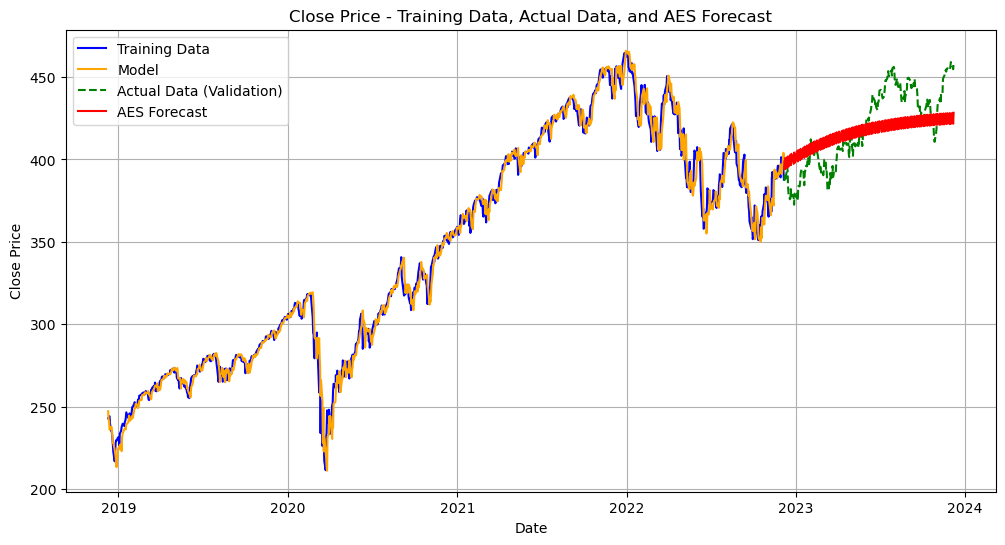

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [47]:
aes_model = ExponentialSmoothing(close_train,
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2,
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1,
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3585.4440315793704
BIC = 3619.8401930339883
Time Series Evaluation Metrics
MSE = 505.6802560896066
MAE = 18.277015923635137
RMSE = 22.487335459978503
MAPE = 0.04243763693501981
r2 = 0.08422315956697213

None


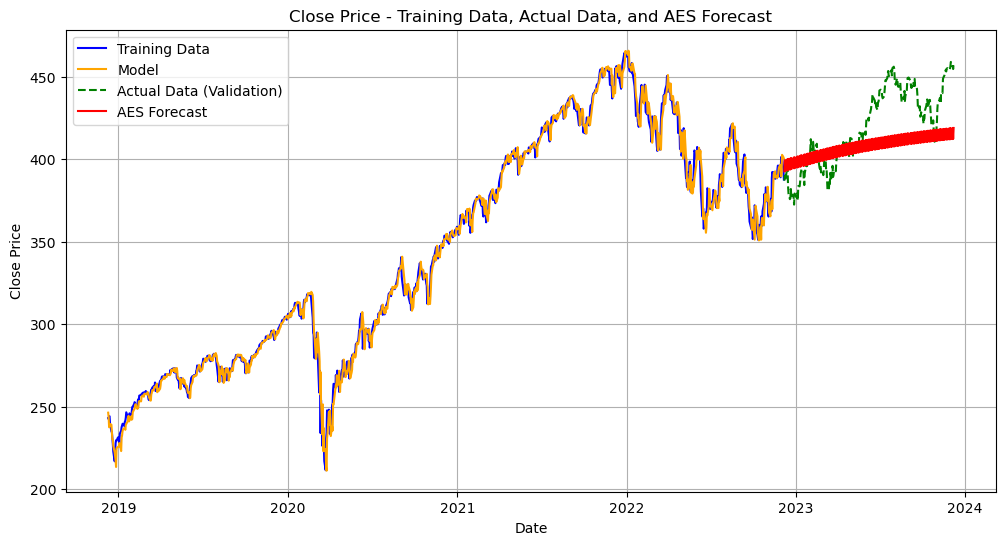

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

#####  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [49]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# TO DO: ADD TREND AND SEASONAL FORECASTS TO ARIMA FORECAST (RESIDUAL COMPONENT) FOR FINAL FORECAST

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                ARIMA(14, 1, 1)   Log Likelihood               -2943.466
Date:                Thu, 07 Dec 2023   AIC                           5918.931
Time:                        14:53:52   BIC                           6003.477
Sample:                    12-10-2018   HQIC                          5950.474
                         - 12-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1378      0.896     -0.154      0.878      -1.894       1.619
ar.L2         -0.1145      0.124     -0.921      0.357      -0.358       0.129
ar.L3          0.1868      0.102      1.837      0.0

In [50]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

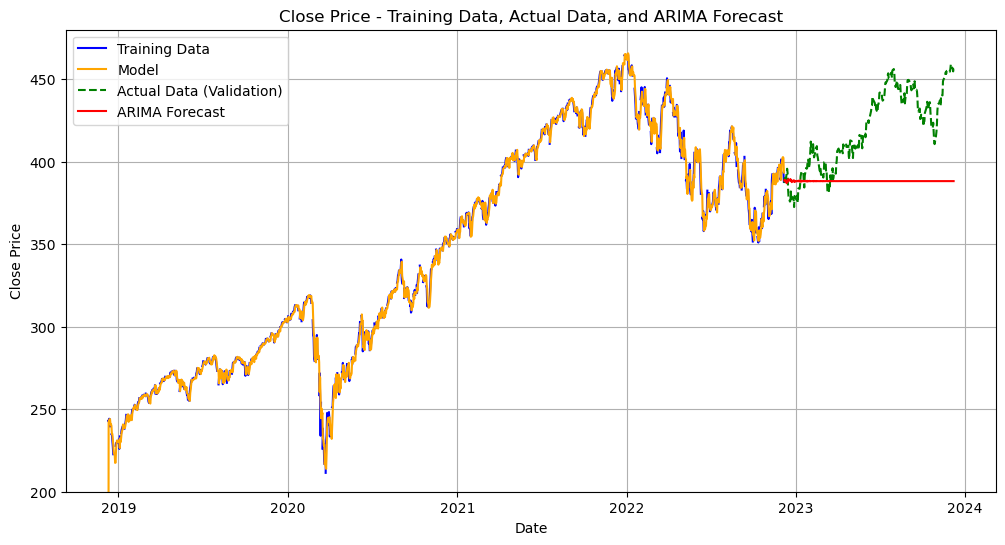

In [51]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [52]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

Open        High         Low       Close  \
Date                                                                        
2022-12-08 00:00:00-05:00  389.016041  391.201606  387.174997  390.098969   
2022-12-09 00:00:00-05:00  388.819121  391.457579  387.056855  387.184845   
2022-12-12 00:00:00-05:00  388.001983  392.766998  387.312850  392.766998   
2022-12-13 00:00:00-05:00  403.862344  404.128149  392.885155  395.740204   
2022-12-14 00:00:00-05:00  395.385732  399.215458  390.167885  393.209991   

                              Volume  open_close  positive   high_low  
Date                                                                   
2022-12-08 00:00:00-05:00   60737900    1.082928         1   4.026609  
2022-12-09 00:00:00-05:00   81447700   -1.634277         0   4.400724  
2022-12-12 00:00:00-05:00   75405800    4.765015         1   5.454148  
2022-12-13 00:00:00-05:00  123782500   -8.122140         0  11.242994  
2022-12-14 00:00:00-05:00  108111300   -2.175740         0   9.047573

In [53]:
spy_desc = hist.copy()
spy_desc['Date'] = pd.to_datetime(spy_desc.index)
spy_desc.insert(0, 'day_of_week', spy_desc['Date'].dt.day_name())
spy_desc.head()

day_of_week        Open        High         Low  \
Date                                                                        
2022-12-08 00:00:00-05:00    Thursday  389.016041  391.201606  387.174997   
2022-12-09 00:00:00-05:00      Friday  388.819121  391.457579  387.056855   
2022-12-12 00:00:00-05:00      Monday  388.001983  392.766998  387.312850   
2022-12-13 00:00:00-05:00     Tuesday  403.862344  404.128149  392.885155   
2022-12-14 00:00:00-05:00   Wednesday  395.385732  399.215458  390.167885   

                                Close     Volume  open_close  positive  \
Date                                                                     
2022-12-08 00:00:00-05:00  390.098969   60737900    1.082928         1   
2022-12-09 00:00:00-05:00  387.184845   81447700   -1.634277         0   
2022-12-12 00:00:00-05:00  392.766998   75405800    4.765015         1   
2022-12-13 00:00:00-05:00  395.740204  123782500   -8.122140         0   
2022-12-14 00:00:00-05:00  393.209991  108111300   -2.175740         0   

                            high_low                      Date  
Date                                                            
2022-12-08 00:00:00-05:00   4.026609 2022-12-08 00:00:00-05:00  
2022-12-09 00:00:00-05:00   4.400724 2022-12-09 00:00:00-05:00  
2022-12-12 00:00:00-05:00   5.454148 2022-12-12 00:00:00-05:00  
2022-12-13 00:00:00-05:00  11.242994 2022-12-13 00:00:00-05:00  
2022-12-14 00:00:00-05:00   9.047573 2022-12-14 00:00:00-05:00

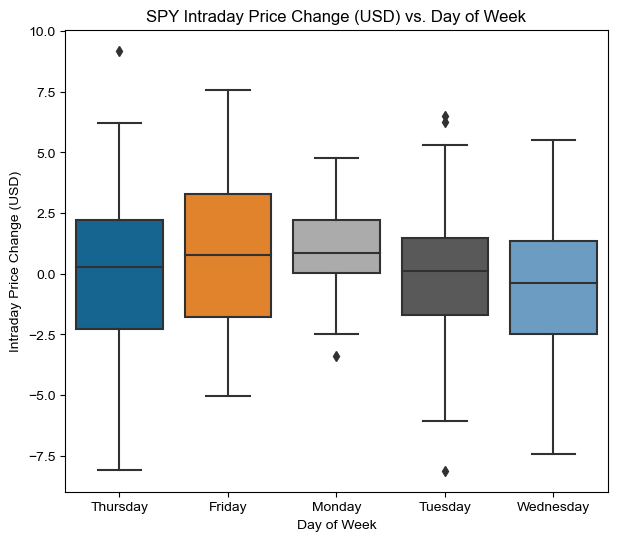

In [54]:
# From Deniega (2023) ADS 505 Final Project
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=spy_desc)
sns.set_style("whitegrid")
plt.title("SPY Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [55]:
day_week_stats = spy_desc.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week     Friday     Monday   Thursday    Tuesday  Wednesday
count        51.000000  45.000000  52.000000  51.000000  52.000000
mean          0.683978   1.075894  -0.050116  -0.076668  -0.533182
std           3.129997   1.933707   3.686132   2.953370   2.884386
min          -5.024221  -3.412140  -8.090198  -8.122140  -7.437469
25%          -1.795289   0.039720  -2.280091  -1.717535  -2.474592
50%           0.751667   0.850006   0.262971   0.089996  -0.397810
75%           3.277120   2.220001   2.207473   1.449651   1.353934
max           7.570007   4.765015   9.187998   6.487128   5.528633

In [56]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [57]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-21 00:00:00-05:00 -1.908784  0.820928  1.631904  2.927551 -41690600.0   
2022-12-22 00:00:00-05:00 -0.415378  2.363773 -3.471455  0.692352  20242800.0   
2022-12-23 00:00:00-05:00  0.415388  0.820891  0.178032  2.343994 -14569900.0   
2022-12-27 00:00:00-05:00 -0.454984 -4.213289 -3.006679 -4.777039 -26529200.0   
2022-12-28 00:00:00-05:00 -1.701164 -2.789065  1.631869 -4.015472 -29209400.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-21 00:00:00-05:00    4.836335       1.0 -0.810975 -13.121983   
2022-12-22 00:00:00-05:00    1.107731       0.0  5.835228  -1.908784   
2022-12-23 00:00:00-05:00    1.928606       0.0  0.642859  -0.415378   
2022-12-27 00:00:00-05:00   -4.322054      -1.0 -1.206609   0.415388   
2022-12-28 00:00:00-05:00   -2.314309       0.0 -4.420933  -0.454984   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-21 00:00:00-05:00 -11.090204 -8.176209   -7.228760  -43278700.0   
2022-12-22 00:00:00-05:00   0.820928  1.631904    2.927551  -41690600.0   
2022-12-23 00:00:00-05:00   2.363773 -3.471455    0.692352   20242800.0   
2022-12-27 00:00:00-05:00   0.820891  0.178032    2.343994  -14569900.0   
2022-12-28 00:00:00-05:00  -4.213289 -3.006679   -4.777039  -26529200.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-21 00:00:00-05:00         5.893223            1.0      -2.913995   
2022-12-22 00:00:00-05:00         4.836335            1.0      -0.810975   
2022-12-23 00:00:00-05:00         1.107731            0.0       5.835228   
2022-12-27 00:00:00-05:00         1.928606            0.0       0.642859   
2022-12-28 00:00:00-05:00        -4.322054           -1.0      -1.206609   

                           Open_lag2  High_lag2   Low_lag2  Close_lag2  \
Date                                                                     
2022-12-21 00:00:00-05:00 -16.125234 -19.608796 -16.040416  -17.361633   
2022-12-22 00:00:00-05:00 -13.121983 -11.090204  -8.176209   -7.228760   
2022-12-23 00:00:00-05:00  -1.908784   0.820928   1.631904    2.927551   
2022-12-27 00:00:00-05:00  -0.415378   2.363773  -3.471455    0.692352   
2022-12-28 00:00:00-05:00   0.415388   0.820891   0.178032    2.343994   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-21 00:00:00-05:00  -28233200.0        -1.236400            0.0   
2022-12-22 00:00:00-05:00  -43278700.0         5.893223            1.0   
2022-12-23 00:00:00-05:00  -41690600.0         4.836335            1.0   
2022-12-27 00:00:00-05:00   20242800.0         1.107731            0.0   
2022-12-28 00:00:00-05:00  -14569900.0         1.928606            0.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-21 00:00:00-05:00      -3.568380      -22.910624      -21.791803   
2022-12-22 00:00:00-05:00      -2.913995      -16.125234      -19.608796   
2022-12-23 00:00:00-05:00      -0.810975      -13.121983      -11.090204   
2022-12-27 00:00:00-05:00       5.835228       -1.908784        0.820928   
2022-12-28 00:00:00-05:00       0.642859       -0.415378        2.363773   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-21 00:00:00-05:00     -16.027973       -16.677521        -3924500.0   
2022-12-22 00:00:00-05:00     -16.040416       -17.361633       -28233200.0   
2022-12-23 0

#### Reference: https://scikit-learn.org/

              precision    recall  f1-score   support

           0       0.48      0.71      0.57        14
           1       0.81      0.61      0.69        28

    accuracy                           0.64        42
   macro avg       0.64      0.66      0.63        42
weighted avg       0.70      0.64      0.65        42



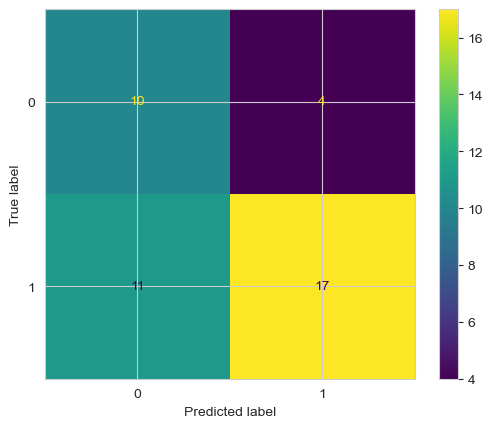

In [58]:
## Change n to lag the data
#for n in range(1, 6):

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance
logreg_pred = logreg_model.predict(X_valid)
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

## Cross-sectional MLP (Neural Network) Model

Using cross-sectional since the dataframe that will be used already statically assigns the lagged values to its respective column. Shuffling across records does not dynamically change the values of the lagged columns.

### Make copy of historical data (differenced at lag=3)

In [60]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-21 00:00:00-05:00 -1.908784  0.820928  1.631904  2.927551 -41690600.0   
2022-12-22 00:00:00-05:00 -0.415378  2.363773 -3.471455  0.692352  20242800.0   
2022-12-23 00:00:00-05:00  0.415388  0.820891  0.178032  2.343994 -14569900.0   
2022-12-27 00:00:00-05:00 -0.454984 -4.213289 -3.006679 -4.777039 -26529200.0   
2022-12-28 00:00:00-05:00 -1.701164 -2.789065  1.631869 -4.015472 -29209400.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-21 00:00:00-05:00    4.836335       1.0 -0.810975 -13.121983   
2022-12-22 00:00:00-05:00    1.107731       0.0  5.835228  -1.908784   
2022-12-23 00:00:00-05:00    1.928606       0.0  0.642859  -0.415378   
2022-12-27 00:00:00-05:00   -4.322054      -1.0 -1.206609   0.415388   
2022-12-28 00:00:00-05:00   -2.314309       0.0 -4.420933  -0.454984   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-21 00:00:00-05:00 -11.090204 -8.176209   -7.228760  -43278700.0   
2022-12-22 00:00:00-05:00   0.820928  1.631904    2.927551  -41690600.0   
2022-12-23 00:00:00-05:00   2.363773 -3.471455    0.692352   20242800.0   
2022-12-27 00:00:00-05:00   0.820891  0.178032    2.343994  -14569900.0   
2022-12-28 00:00:00-05:00  -4.213289 -3.006679   -4.777039  -26529200.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-21 00:00:00-05:00         5.893223            1.0      -2.913995   
2022-12-22 00:00:00-05:00         4.836335            1.0      -0.810975   
2022-12-23 00:00:00-05:00         1.107731            0.0       5.835228   
2022-12-27 00:00:00-05:00         1.928606            0.0       0.642859   
2022-12-28 00:00:00-05:00        -4.322054           -1.0      -1.206609   

                           Open_lag2  High_lag2   Low_lag2  Close_lag2  \
Date                                                                     
2022-12-21 00:00:00-05:00 -16.125234 -19.608796 -16.040416  -17.361633   
2022-12-22 00:00:00-05:00 -13.121983 -11.090204  -8.176209   -7.228760   
2022-12-23 00:00:00-05:00  -1.908784   0.820928   1.631904    2.927551   
2022-12-27 00:00:00-05:00  -0.415378   2.363773  -3.471455    0.692352   
2022-12-28 00:00:00-05:00   0.415388   0.820891   0.178032    2.343994   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-21 00:00:00-05:00  -28233200.0        -1.236400            0.0   
2022-12-22 00:00:00-05:00  -43278700.0         5.893223            1.0   
2022-12-23 00:00:00-05:00  -41690600.0         4.836335            1.0   
2022-12-27 00:00:00-05:00   20242800.0         1.107731            0.0   
2022-12-28 00:00:00-05:00  -14569900.0         1.928606            0.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-21 00:00:00-05:00      -3.568380      -22.910624      -21.791803   
2022-12-22 00:00:00-05:00      -2.913995      -16.125234      -19.608796   
2022-12-23 00:00:00-05:00      -0.810975      -13.121983      -11.090204   
2022-12-27 00:00:00-05:00       5.835228       -1.908784        0.820928   
2022-12-28 00:00:00-05:00       0.642859       -0.415378        2.363773   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-21 00:00:00-05:00     -16.027973       -16.677521        -3924500.0   
2022-12-22 00:00:00-05:00     -16.040416       -17.361633       -28233200.0   
2022-12-23 0

### Preprocess dataframes for RobustScaler due to expected outlier stock price movements

In [61]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

Open      High       Low     Close    Volume  \
Date                                                                          
2022-12-21 00:00:00-05:00 -0.351329 -0.011263  0.064899  0.216913 -1.158293   
2022-12-22 00:00:00-05:00 -0.162291  0.203554 -0.650217 -0.069547  0.683609   
2022-12-23 00:00:00-05:00 -0.057132 -0.011269 -0.138827  0.142125 -0.351722   
2022-12-27 00:00:00-05:00 -0.167305 -0.712200 -0.585090 -0.770496 -0.707392   
2022-12-28 00:00:00-05:00 -0.325048 -0.513899  0.064894 -0.672895 -0.787101   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-21 00:00:00-05:00    0.893240         1 -0.354283  -1.741303   
2022-12-22 00:00:00-05:00    0.198131         0  2.261029  -0.341674   
2022-12-23 00:00:00-05:00    0.351164         1  0.217807  -0.155268   
2022-12-27 00:00:00-05:00   -0.814122         0 -0.509967  -0.051572   
2022-12-28 00:00:00-05:00   -0.439826         0 -1.774819  -0.160211   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-21 00:00:00-05:00  -1.641886 -1.290783   -1.064183    -1.198209   
2022-12-22 00:00:00-05:00  -0.011076  0.073719    0.222234    -1.151265   
2022-12-23 00:00:00-05:00   0.200162 -0.636259   -0.060880     0.679462   
2022-12-27 00:00:00-05:00  -0.011081 -0.128543    0.148320    -0.349588   
2022-12-28 00:00:00-05:00  -0.700334 -0.571599   -0.753644    -0.703100   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-21 00:00:00-05:00         1.043347            0.5      -1.181831   
2022-12-22 00:00:00-05:00         0.854795            0.5      -0.354283   
2022-12-23 00:00:00-05:00         0.189604            0.0       2.261029   
2022-12-27 00:00:00-05:00         0.336050            0.0       0.217807   
2022-12-28 00:00:00-05:00        -0.779082           -0.5      -0.509967   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-21 00:00:00-05:00  -2.091289  -2.792267 -2.357849   -2.347632   
2022-12-22 00:00:00-05:00  -1.719131  -1.632566 -1.276169   -1.064183   
2022-12-23 00:00:00-05:00  -0.329608  -0.011013  0.072884    0.222234   
2022-12-27 00:00:00-05:00  -0.144547   0.199026 -0.629055   -0.060880   
2022-12-28 00:00:00-05:00  -0.041600  -0.011018 -0.127088    0.148320   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-21 00:00:00-05:00    -0.753470        -0.232994            0.0   
2022-12-22 00:00:00-05:00    -1.198209         1.063427            0.5   
2022-12-23 00:00:00-05:00    -1.151265         0.871247            0.5   
2022-12-27 00:00:00-05:00     0.679462         0.193253            0.0   
2022-12-28 00:00:00-05:00    -0.349588         0.342517            0.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-21 00:00:00-05:00      -1.433642       -2.927083       -3.060084   
2022-12-22 00:00:00-05:00      -1.177157       -2.087693       -2.765720   
2022-12-23 00:00:00-05:00      -0.352882       -1.716175       -1.617045   
2022-12-27 00:00:00-05:00       2.252087       -0.329041       -0.010908   
2022-12-28 00:00:00-05:00       0.216946       -0.144298        0.197134   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-21 00:00:00-05:00      -2.279964        -2.237677         -0.034914   
2022-12-22 00:00:00-05:00      -2.281624        -2.323435         -0.753470   
2022-12-23 00:00:00-05:00      -1

### Partition

In [62]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 63), (42, 63), (200,), (42,))

### Cross-sectional MLP (Neural Network) Model Fitting and Confusion Matrix

##### Gridsearch for the best set of parameters
#### To run and find best parameter takes some time

In [63]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16,
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)',
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnv

MLPClassifier(activation='tanh', hidden_layer_sizes=1, max_iter=2000,
              random_state=14, solver='sgd')

##### Fit parameters to MLP model

In [64]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              solver='sgd')

##### Evaluate model with Confusion Matrix

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.93      1.00      0.97        28

    accuracy                           0.95        42
   macro avg       0.97      0.93      0.94        42
weighted avg       0.96      0.95      0.95        42



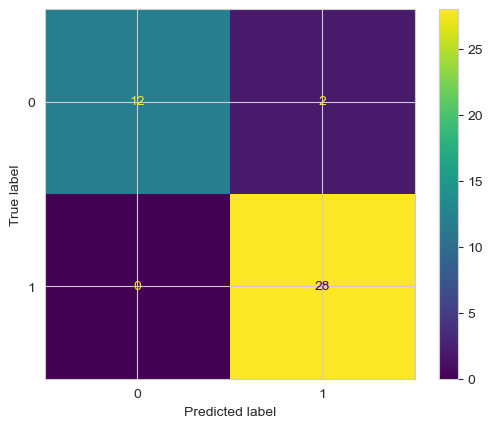

In [65]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

## TEST: Try different parameters (hidden layers, solvers, etc.)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.96      0.93      0.95        28

    accuracy                           0.93        42
   macro avg       0.91      0.93      0.92        42
weighted avg       0.93      0.93      0.93        42



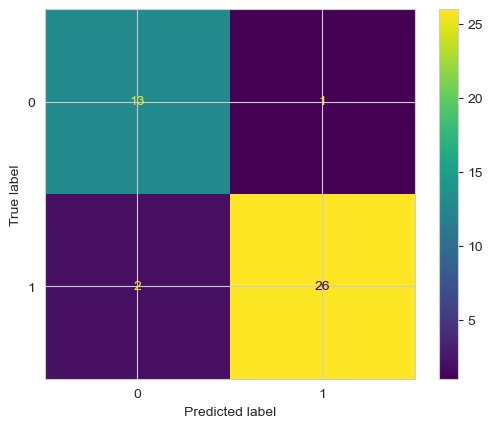

In [66]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

##### Hidden Layers (3,2) shows .95 accuracy!!!

### MLP Regressor

In [67]:
mlpr = hist.copy()

y = hist['Close']
X = mlpr.drop(['Close'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 7), (51, 7), (200,), (51,))

### MLP Regressor Parameter search

In [68]:
# Inspired by Deniega (2023) ADS 505 Final
# Finding best estimator will take some time
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16,
                           '(2,2)', '(3,2)', '(4,2)', '(5,2)', '(3,3)', '(3,4)', '(3,5)', '(4,3)', '(4,4)',
                           '(4,5)', '(5,4)', '(5,5)', '(2,2,2)', '(2,2,3)', '(2,3,2)', '(3,2,2)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPRegressor(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: Run

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [69]:
# Model and fitting
mlpr_model = MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')
mlpr_model.fit(X_train,y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=8, max_iter=500, random_state=14,
             solver='lbfgs')

In [70]:
mlpr_pred = mlpr_model.predict(X_valid)
mlpr_pred = pd.Series(mlpr_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlpr_pred.index)
#close_valid.shape, mlpr_pred.shape
ts_eval_metrics(y_valid, mlpr_pred)

Time Series Evaluation Metrics
MSE = 2.1544339862679363
MAE = 1.1072717534309282
RMSE = 1.467799027887652
MAPE = 0.00256020653193213
r2 = 0.9889024153344189



## Amazon Closing Stock Price Analysis and Forecasting 

In [71]:
# Download market data for Amazon:

amzn = yf.Ticker("AMZN")
#amzn.history_metadata

In [72]:
# Import Amazon stock dataset:

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

Open       High        Low      Close  \
Date                                                                    
2018-12-10 00:00:00-05:00  81.192001  82.899498  79.543503  82.051498   
2018-12-11 00:00:00-05:00  83.900002  83.973503  80.980003  82.162003   
2018-12-12 00:00:00-05:00  83.449997  85.249496  83.013496  83.177002   
2018-12-13 00:00:00-05:00  84.000000  84.606003  82.074997  82.918999   
2018-12-14 00:00:00-05:00  81.900002  82.128502  79.250000  79.595497   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-12-10 00:00:00-05:00  149896000        0.0           0.0  
2018-12-11 00:00:00-05:00  124894000        0.0           0.0  
2018-12-12 00:00:00-05:00  131960000        0.0           0.0  
2018-12-13 00:00:00-05:00  105426000        0.0           0.0  
2018-12-14 00:00:00-05:00  127344000        0.0           0.0

Open        High         Low       Close  \
Date                                                                        
2023-12-01 00:00:00-05:00  146.000000  147.250000  145.550003  147.029999   
2023-12-04 00:00:00-05:00  145.250000  145.350006  142.809998  144.839996   
2023-12-05 00:00:00-05:00  143.550003  148.570007  143.130005  146.880005   
2023-12-06 00:00:00-05:00  147.580002  147.850006  144.279999  144.520004   
2023-12-07 00:00:00-05:00  146.149994  147.914993  145.339996  146.880005   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-12-01 00:00:00-05:00  39924600        0.0           0.0  
2023-12-04 00:00:00-05:00  48294200        0.0           0.0  
2023-12-05 00:00:00-05:00  46822400        0.0           0.0  
2023-12-06 00:00:00-05:00  39679000        0.0           0.0  
2023-12-07 00:00:00-05:00  44424386        0.0           0.0

Open         High          Low        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean    126.794137   128.356044   125.124271   126.756769  7.716229e+07   
std      31.682717    31.968351    31.310496    31.598176  3.493791e+07   
min      67.300003    69.801498    65.349998    67.197998  1.762600e+07   
25%      95.086500    96.093252    94.007500    95.043875  5.379700e+07   
50%     125.700001   127.440002   124.129997   125.980003  6.672500e+07   
75%     158.346878   159.930752   156.224998   158.093746  9.053650e+07   
max     187.199997   188.654007   184.839493   186.570496  3.113460e+08   

       Dividends  Stock Splits  
count     1258.0   1258.000000  
mean         0.0      0.015898  
std          0.0      0.563884  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0     20.000000

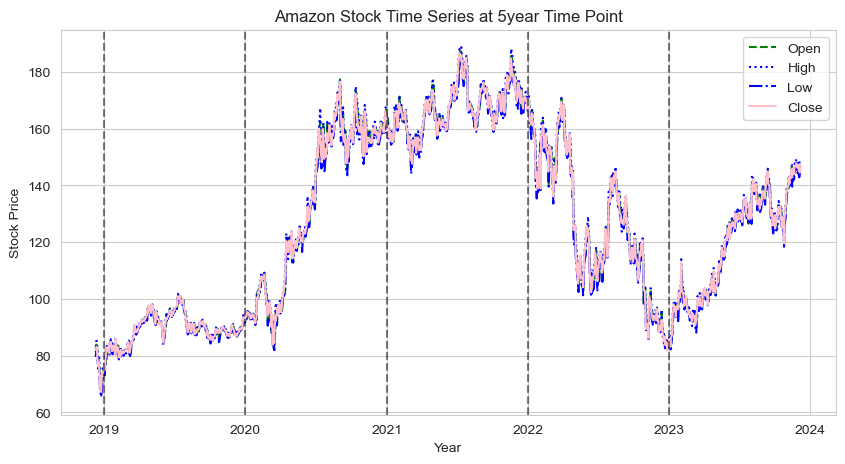

In [73]:
# Plot initial Amazon stock time series at 5y time point:

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

### Partition train and validation datasets

In [74]:
# Partition train and validation datasets:

past_year0 = amzn_df.iloc[-252:] # 252 trading days per year
b_past_year = amzn_df.iloc[:-len(past_year0)]

train = b_past_year['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.iloc[-len(past_year0):]
val_close = valid['Close'].asfreq('D')
val_close = val_close.ffill()

### Test of Stationarity Through Augmented Dickey–Fuller Method

In [75]:
# Determine dataset stationarity:
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.413038
p-value: 0.576010
Critical Values:
{'1%': -3.43484922137066, '5%': -2.8635271063560412, '10%': -2.5678279184465946}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [76]:
# Fit close stock price dataset to STL:

stl = STL(amzn_df['Close'], period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

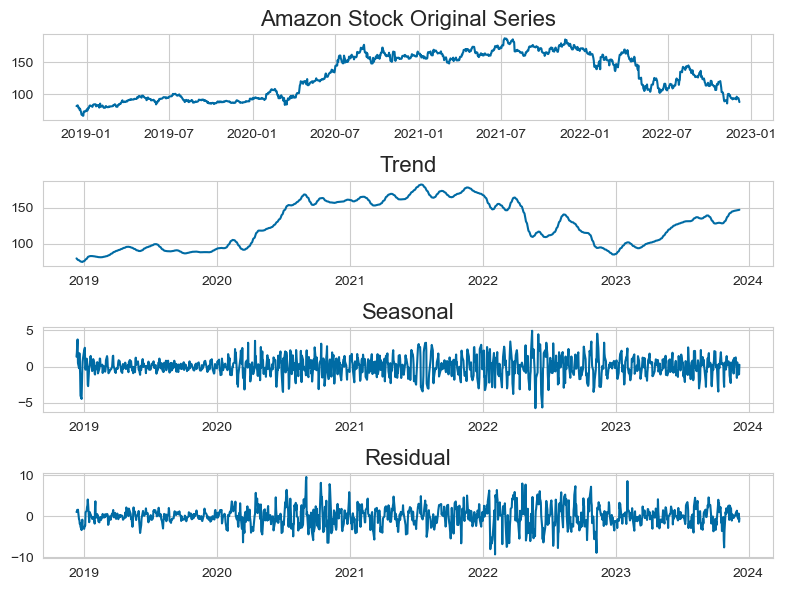

In [77]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_df)
plt.title('Amazon Stock Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [78]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

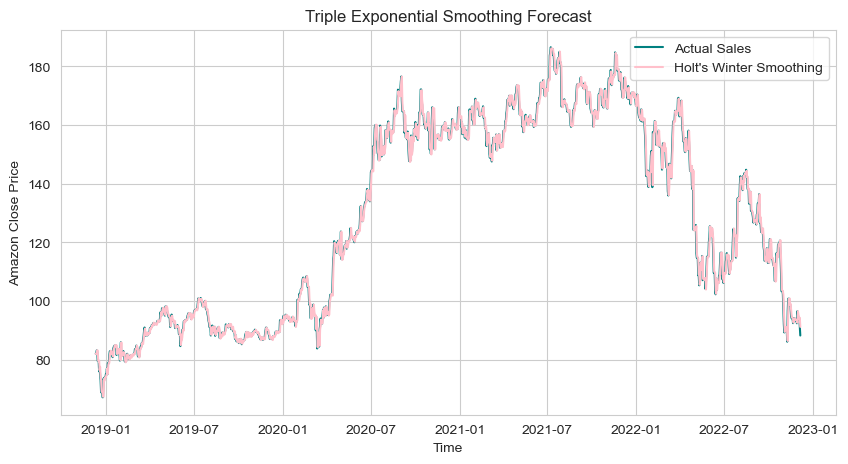

In [79]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection Using STL Decomposition

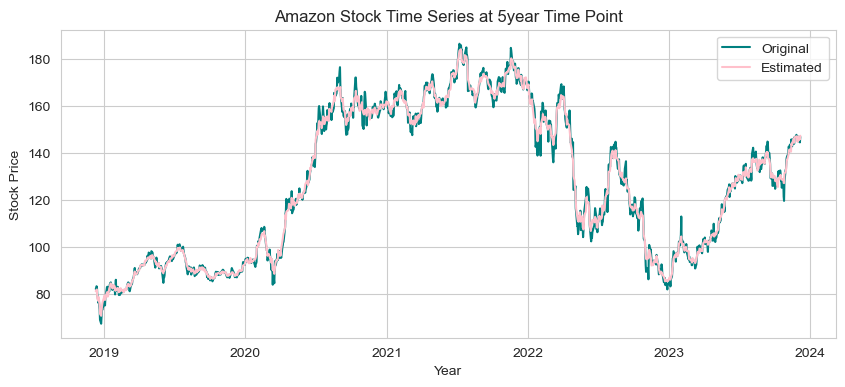

In [80]:
# Plot original Amazon Close time series vs Forecasted time series:

estimated = trend + seasonal # from STL
plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'], label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Taking residuals and detecting anomaly at 3std. dev:

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

Text(0.5, 1.0, 'Amazon at 5year Time Point')

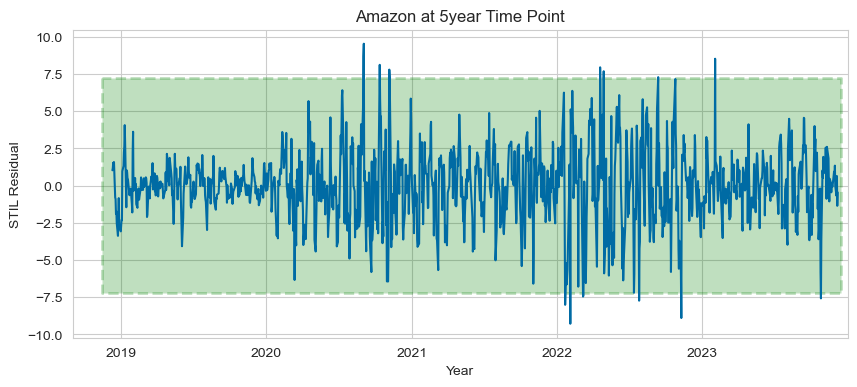

In [82]:
# Plot residual threshold:

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('Amazon at 5year Time Point')

In [83]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_df['Close'][(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

Text(0.5, 1.0, 'Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

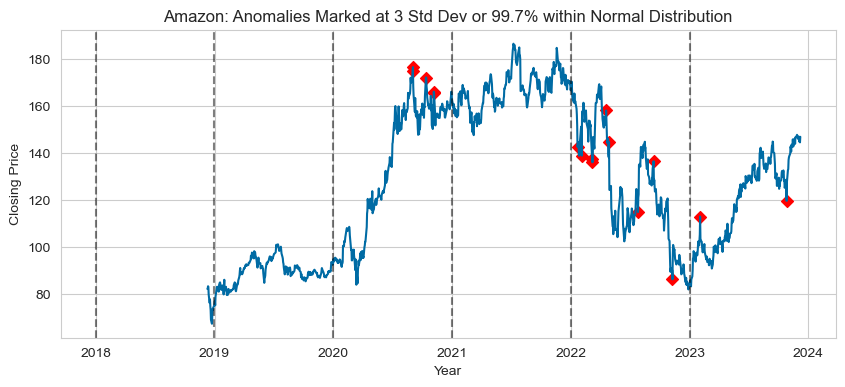

In [84]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'])

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')


# Plot shows anomalies detected outside of +/- 3 Std Dev of normal distribution in red. 
# Anomaly detection successful in detecting times market is most volitile.  

In [85]:
# Anomalies identified outside 3std dev of residuals:

anomalies.head()

Close
Date                                 
2020-09-01 00:00:00-04:00  174.955994
2020-09-02 00:00:00-04:00  176.572495
2020-10-12 00:00:00-04:00  172.146500
2020-11-05 00:00:00-05:00  166.100006
2020-11-06 00:00:00-05:00  165.568497

### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

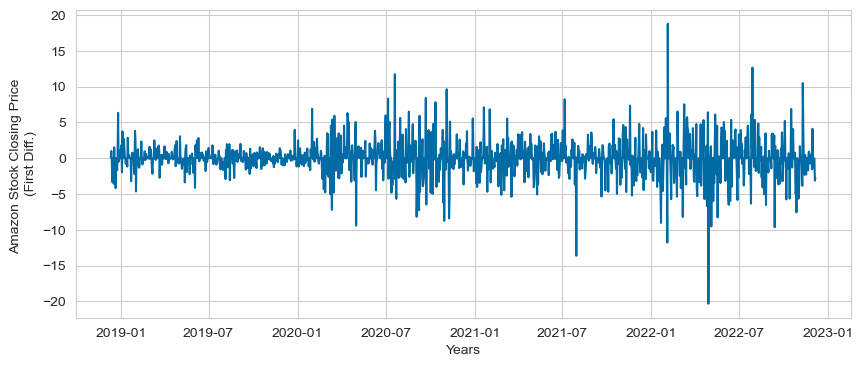

In [86]:
# Removing trend by applying the first Difference:

diff_ts = amzn_train.diff().dropna()

# Plot first difference:

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [87]:
# Determine dataset stationarity:
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -39.811873
p-value: 0.000000
Critical Values:
{'1%': -3.43484922137066, '5%': -2.8635271063560412, '10%': -2.5678279184465946}
Time series is stationary


### Selecting a Model

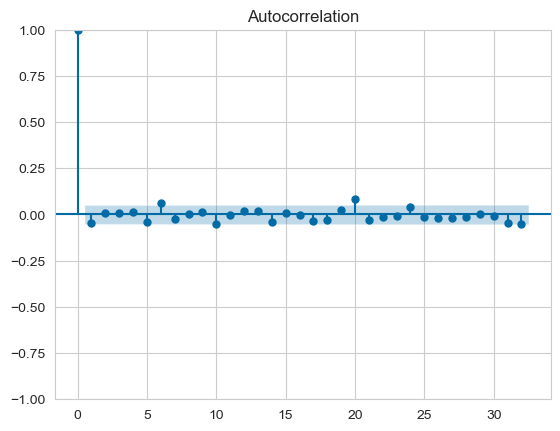

None

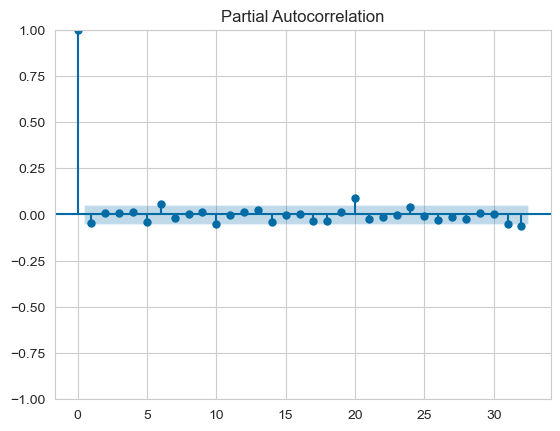

None

In [88]:
# ACF suggest MA Lag 1, 6, 10, 20, 31, 32

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1, 6, 10, 20, 31, 32

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria:

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood
>
>($k$) = a number of parameters
>
>($n$) = a number of samples used for fitting


#### Auto-ARIMA Model

In [89]:
# Auto ARIMA Model:

auto_arima_model = auto_arima(amzn_train, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

arima_pred0 = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6719.489, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6725.254, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6724.492, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6724.529, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6723.258, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6728.350, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6728.446, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6724.238, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6726.458, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6729.001, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6730.334, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6726.178, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6717.838, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [90]:
# ARIMA Model and Forecast at ARIMA(2,1,2):

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m = sm.tsa.ARIMA(amzn_train, order=(2,1,2)).fit()
print(arima_m.summary())

arima_pred1 = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3353.919
Date:                Thu, 07 Dec 2023   AIC                           6717.838
Time:                        14:57:46   BIC                           6744.259
Sample:                    12-10-2018   HQIC                          6727.695
                         - 12-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5632      0.011    -50.467      0.000      -0.585      -0.541
ar.L2         -0.9810      0.011    -89.908      0.000      -1.002      -0.960
ma.L1          0.5429      0.012     46.547      0.0

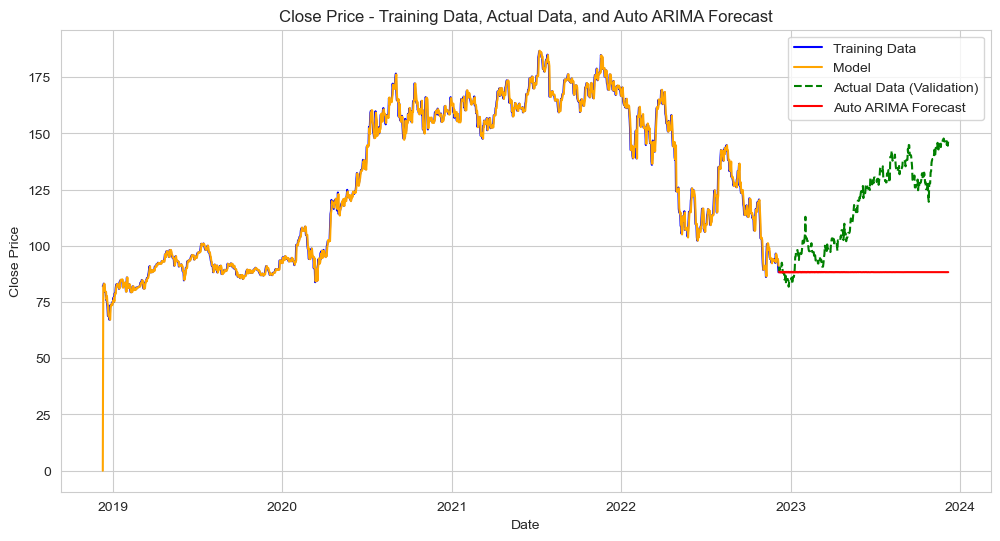

In [91]:
# Plot Auto ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred1, label='Auto ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and Auto ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot shows best performing ARIMA parameter at (2, 1, 2) values of p,d,q. 
# Although, the auto forecast did very poorly in predicting the validation dataset. 

#### ARIMA Model

In [92]:
# AR lag optimization:

ar_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ar_order0 in enumerate(ar_orders0):
    ar_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(ar_order0,1,1),trend='n')
    ar_model_fit0 = ar_model0.fit()
    fitted_model_dict[ar_order0] = ar_model_fit0

for ar_order0 in ar_orders0:
    print('AIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].aic))
    print('BIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].bic))
    print('\n')

AIC for AR(1): 6724.462730588234
BIC for AR(1): 6740.31513500682


AIC for AR(6): 6726.403156042263
BIC for AR(6): 6768.676234491824


AIC for AR(10): 6730.049408092233
BIC for AR(10): 6793.459025766575


AIC for AR(20): 6730.0960653162765
BIC for AR(20): 6846.347031052571


AIC for AR(31): 6740.216916963296
BIC for AR(31): 6914.593365567738


AIC for AR(32): 6737.185303282478
BIC for AR(32): 6916.845886693115




##### Result:

AR order 1 has the lowest AIC and BIC scores.

In [93]:
# MA lag optimization:

ma_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ma_order0 in enumerate(ma_orders0):
    ma_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(1,1,ma_order0),trend='n')
    ma_model_fit0 = ma_model0.fit()
    fitted_model_dict[ma_order0] = ma_model_fit0

for ma_order0 in ma_orders0:
    print('AIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].aic))
    print('BIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].bic))
    print('\n')

AIC for AR(1): 6724.462730588234
BIC for AR(1): 6740.31513500682


AIC for AR(6): 6725.916961954248
BIC for AR(6): 6768.19004040381


AIC for AR(10): 6730.648894229896
BIC for AR(10): 6794.058511904238


AIC for AR(20): 6728.024925554986
BIC for AR(20): 6844.2758912912805


AIC for AR(31): 6739.54789501218
BIC for AR(31): 6913.924343616622


AIC for AR(32): 6738.763016499044
BIC for AR(32): 6918.423599909681




##### Result:

MA order 1 has the lowest AIC and BIC scores.

In [94]:
# ARIMA Model and Forecast at ARIMA(1,1,1):

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m0 = sm.tsa.ARIMA(amzn_train, order=(1,1,1)).fit()
print(arima_m0.summary())

arima_pred2 = arima_m0.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3359.231
Date:                Thu, 07 Dec 2023   AIC                           6724.463
Time:                        14:58:28   BIC                           6740.315
Sample:                    12-10-2018   HQIC                          6730.377
                         - 12-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1464      0.586     -0.250      0.803      -1.295       1.002
ma.L1          0.1031      0.585      0.176      0.860      -1.044       1.250
sigma2         5.8902      0.105     55.853      0.0

In [95]:
# Statistical Metrics:

print('AIC = %s' %(arima_m0.aic))
print('BIC = %s' %(arima_m0.bic))
arima0_metrics = ts_eval_metrics(val_close, arima_pred2)

AIC = 6724.462730588234
BIC = 6740.31513500682
Time Series Evaluation Metrics
MSE = 1192.3623374272072
MAE = 29.17222101327893
RMSE = 34.53060001545307
MAPE = 0.22894527059170452
r2 = -2.255932643209844



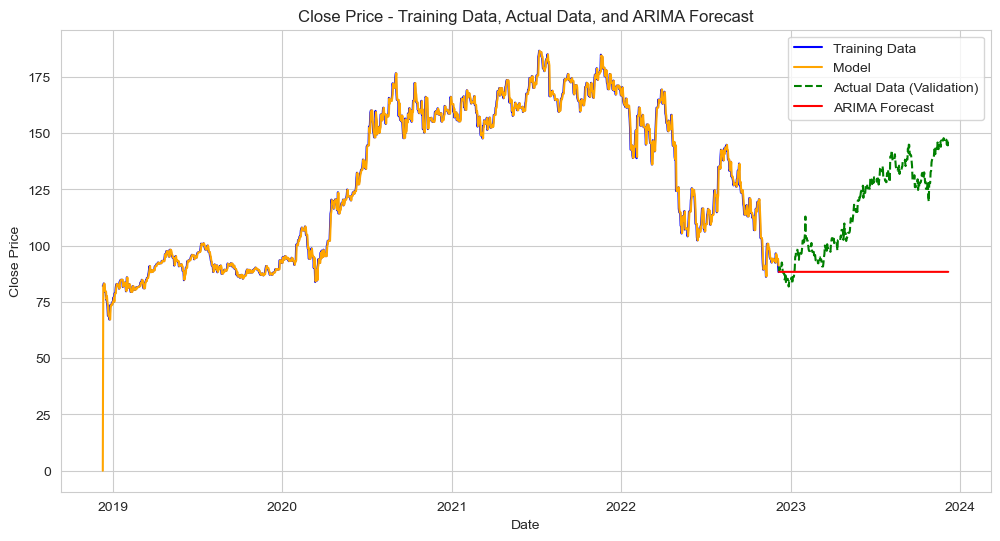

In [96]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m0.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred2, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Same with auto-ARIMA, ARIMA with (1,1,1) parameters selected through metric scores performance did very poorly. 
# Manual selection of ARIMA parameters did not predict closing prices well compared to the validation dataset. 

#### AES Model

In [97]:
# Define AES parameters for optimization:

aes_param_trend0 = ['add', 'mul', None]
aes_param_seasonal0 = ['add', 'mul', None] # set to mul by default
aes_param_initial_method0 = [None, 'estimated', 'heuristic', 'legacy-heuristic']


fitted_model_dict0 = {}

In [98]:
# Trend parameter optimization:

for i in aes_param_trend0:
    aes_model2 = ExponentialSmoothing(amzn_train,
                                     trend=i,
                                     damped_trend=False, # Error message: Can only dampen the trend component
                                     seasonal= 'mul',
                                     seasonal_periods= 252,
                                     initialization_method='heuristic'
                                    )
    aes_model2 = aes_model2.fit(
                             )

    print('Results for Trend %s' % (i))
    print('AIC = %s' %(aes_model2.aic))
    print('BIC = %s' %(aes_model2.bic))
    aes_pred2 = aes_model2.forecast(steps=len(val_close))
    aes_eval_metrics2 = ts_eval_metrics(val_close, aes_pred2)

Results for Trend add
AIC = 2933.4144282600887
BIC = 4286.328581877651
Time Series Evaluation Metrics
MSE = 715.6255722654894
MAE = 22.0348749875091
RMSE = 26.751178894872826
MAPE = 0.17162904143922328
r2 = -0.9541280262864544

Results for Trend mul
AIC = 2934.446272264975
BIC = 4287.360425882538
Time Series Evaluation Metrics
MSE = 689.4481294099556
MAE = 21.635593196342995
RMSE = 26.257344294691258
MAPE = 0.16855750462129396
r2 = -0.8826464069550355

Results for Trend None
AIC = 2929.0842466913605
BIC = 4271.428758483786
Time Series Evaluation Metrics
MSE = 1144.1477518762529
MAE = 28.262586519551377
RMSE = 33.82525316795505
MAPE = 0.22104057336012292
r2 = -2.1242751444390313



##### Result

No trend parameter has the lowest AIC and BIC scores.

In [99]:
# Initialization method optimization:

for i in aes_param_initial_method0:
    aes_model3 = ExponentialSmoothing(amzn_train,
                                     trend= None,
                                     seasonal= 'mul',
                                     seasonal_periods= 252,
                                     initialization_method=i
                                    )
    aes_model3 = aes_model3.fit(
                             )

    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model3.aic))
    print('BIC = %s' %(aes_model3.bic))
    aes_pred3 = aes_model3.forecast(steps=len(val_close))
    aes_eval_metrics3 = ts_eval_metrics(val_close, aes_pred3)

Results for Initialization Method None
AIC = 3609.136123094315
BIC = 4951.4806348867405
Time Series Evaluation Metrics
MSE = 1581.3623074487302
MAE = 35.49966372284051
RMSE = 39.766346418155265
MAPE = 0.28696404345211984
r2 = -3.3181581604411354

Results for Initialization Method estimated
AIC = 2770.3129059124017
BIC = 4112.657417704827
Time Series Evaluation Metrics
MSE = 1395.3739939637549
MAE = 32.089175134397586
RMSE = 37.3547051114549
MAPE = 0.2538659389046374
r2 = -2.81028785783

Results for Initialization Method heuristic
AIC = 2929.0842466913605
BIC = 4271.428758483786
Time Series Evaluation Metrics
MSE = 1144.1477518762529
MAE = 28.262586519551377
RMSE = 33.82525316795505
MAPE = 0.22104057336012292
r2 = -2.1242751444390313

Results for Initialization Method legacy-heuristic
AIC = 3609.136123094315
BIC = 4951.4806348867405
Time Series Evaluation Metrics
MSE = 1581.3623074487302
MAE = 35.49966372284051
RMSE = 39.766346418155265
MAPE = 0.28696404345211984
r2 = -3.318158160441135

##### Result

For initialization method, heuristic and estimated methods performed the best.

In [100]:
# Final AES Model on train dataset:

aes_modelf = ExponentialSmoothing(amzn_train,
                                 trend= None,
                                 seasonal= 'mul', # set by default, add is poor performer visually
                                 seasonal_periods= 252, #252 trading days per year forecast
                                 initialization_method='heuristic')

aes_modelf = aes_modelf.fit(smoothing_level=.5,
                              smoothing_trend=.5)


aes_predf = aes_modelf.forecast(steps=len(val_close))
aes_eval_metricsf = ts_eval_metrics(val_close, aes_predf)

print('AIC = %s' %(aes_modelf.aic))
print('BIC = %s' %(aes_modelf.bic))

Time Series Evaluation Metrics
MSE = 1083.8029995977938
MAE = 27.299075956457028
RMSE = 32.92116339982221
MAPE = 0.2129806669271125
r2 = -1.9594943201689579

AIC = 3279.5590104150165
BIC = 4621.903522207442


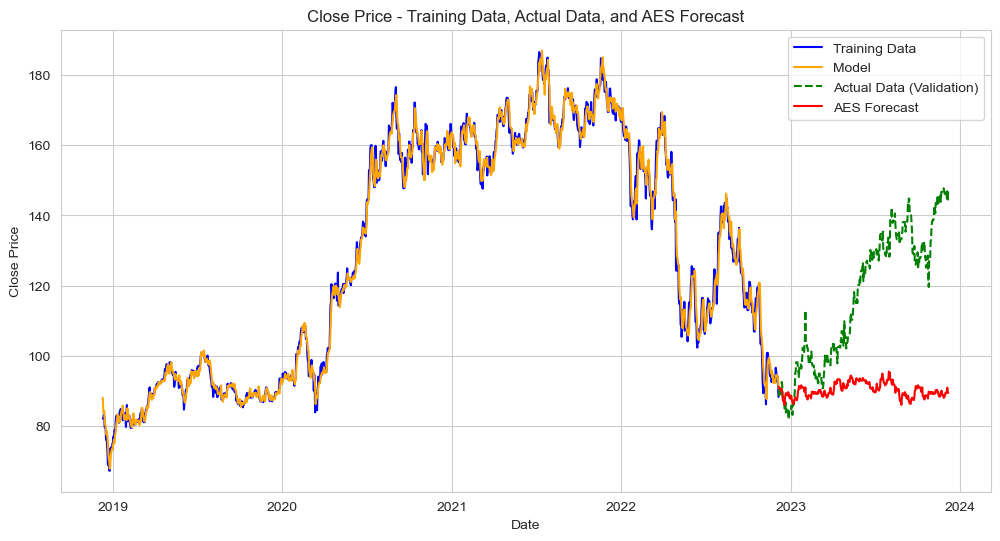

In [101]:
# Plot AES Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(aes_modelf.fittedvalues, label="Model", color = 'orange')
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, aes_predf, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()


# AES forecasting model performed better than ARIMA model. 
# But compared to the validation dataset, AES did poorly overall. 

#### Logistic Regression

In [102]:
# Pull 1 year Amazon history log:

amzn_1 = yf.Ticker("AMZN")
hist0 = amzn_1.history(period = '1y')


# Create new predictors and outcome variables:

hist0['open_close'] = hist0['Close'] - hist0['Open']
hist0['positive'] = np.where(hist0['open_close'] > 0, 1, 0)

hist0['high_low'] = hist0['High'] - hist0['Low']
hist0 = hist0.drop(['Dividends', 'Stock Splits'], axis=1)

hist0.head()

Open       High        Low      Close  \
Date                                                                    
2022-12-08 00:00:00-05:00  89.239998  90.860001  87.879997  90.349998   
2022-12-09 00:00:00-05:00  88.900002  90.300003  88.629997  89.089996   
2022-12-12 00:00:00-05:00  89.209999  90.580002  87.870003  90.550003   
2022-12-13 00:00:00-05:00  95.230003  96.250000  90.519997  92.489998   
2022-12-14 00:00:00-05:00  92.500000  93.459999  89.870003  91.580002   

                              Volume  open_close  positive  high_low  
Date                                                                  
2022-12-08 00:00:00-05:00   73305900    1.110001         1  2.980003  
2022-12-09 00:00:00-05:00   67398500    0.189995         1  1.670006  
2022-12-12 00:00:00-05:00   61999800    1.340004         1  2.709999  
2022-12-13 00:00:00-05:00  100212000   -2.740005         0  5.730003  
2022-12-14 00:00:00-05:00   70298000   -0.919998         0  3.589996

In [103]:
amzn_desc = hist0.copy()
amzn_desc['Date'] = pd.to_datetime(amzn_desc.index)
amzn_desc.insert(0, 'day_of_week', amzn_desc['Date'].dt.day_name())
amzn_desc.head()

day_of_week       Open       High        Low  \
Date                                                                     
2022-12-08 00:00:00-05:00    Thursday  89.239998  90.860001  87.879997   
2022-12-09 00:00:00-05:00      Friday  88.900002  90.300003  88.629997   
2022-12-12 00:00:00-05:00      Monday  89.209999  90.580002  87.870003   
2022-12-13 00:00:00-05:00     Tuesday  95.230003  96.250000  90.519997   
2022-12-14 00:00:00-05:00   Wednesday  92.500000  93.459999  89.870003   

                               Close     Volume  open_close  positive  \
Date                                                                    
2022-12-08 00:00:00-05:00  90.349998   73305900    1.110001         1   
2022-12-09 00:00:00-05:00  89.089996   67398500    0.189995         1   
2022-12-12 00:00:00-05:00  90.550003   61999800    1.340004         1   
2022-12-13 00:00:00-05:00  92.489998  100212000   -2.740005         0   
2022-12-14 00:00:00-05:00  91.580002   70298000   -0.919998         0   

                           high_low                      Date  
Date                                                           
2022-12-08 00:00:00-05:00  2.980003 2022-12-08 00:00:00-05:00  
2022-12-09 00:00:00-05:00  1.670006 2022-12-09 00:00:00-05:00  
2022-12-12 00:00:00-05:00  2.709999 2022-12-12 00:00:00-05:00  
2022-12-13 00:00:00-05:00  5.730003 2022-12-13 00:00:00-05:00  
2022-12-14 00:00:00-05:00  3.589996 2022-12-14 00:00:00-05:00

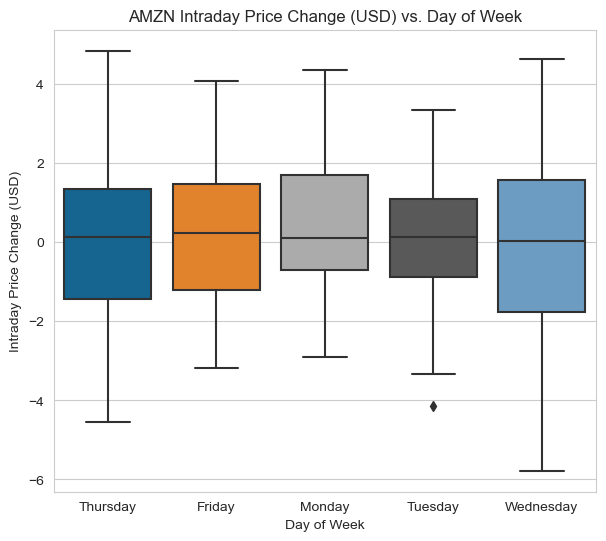

In [104]:
target_y = 'open_close'
column_x = 'day_of_week'

plt.figure(figsize=(7, 6))
sns.boxplot(x=column_x, y=target_y, data=amzn_desc)
sns.set_style("whitegrid")
plt.title("AMZN Intraday Price Change (USD) vs. Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Intraday Price Change (USD)")
plt.show()

In [105]:
day_week_stats = amzn_desc.groupby('day_of_week').describe().transpose()
display(day_week_stats.loc['open_close'])

day_of_week     Friday     Monday   Thursday    Tuesday  Wednesday
count        51.000000  45.000000  52.000000  51.000000  52.000000
mean          0.338039   0.314889   0.096154   0.011568  -0.109807
std           1.889617   1.607839   2.053585   1.625446   2.260142
min          -3.190002  -2.899994  -4.559998  -4.139992  -5.779999
25%          -1.209995  -0.700005  -1.432501  -0.875004  -1.754997
50%           0.220001   0.110001   0.135002   0.119995   0.019997
75%           1.465004   1.690002   1.355001   1.085003   1.579996
max           4.070000   4.350006   4.839996   3.330002   4.620003

In [106]:
hist0_lag = hist0.copy()

lag = 3

hist0_lag = hist0_lag.diff(periods=lag)

for i in range(1, lag+1):
    for col in hist0_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist0_lag[lag_col_name] = hist0_lag[col].shift(i)

hist0_lag = hist0_lag.dropna()

In [107]:
pd.set_option('display.max_columns', 70)
display(hist0_lag.head())

Open      High       Low     Close      Volume  \
Date                                                                            
2022-12-21 00:00:00-05:00 -2.089996 -2.119995 -1.520004 -1.090004 -86876900.0   
2022-12-22 00:00:00-05:00 -1.990005 -1.949997 -2.260002 -1.129997  -2100200.0   
2022-12-23 00:00:00-05:00 -2.080002 -0.830002 -1.400002  0.059998 -16914600.0   
2022-12-27 00:00:00-05:00 -1.209999 -1.880005 -2.209999 -3.729996  -1983200.0   
2022-12-28 00:00:00-05:00 -2.719994 -2.199997 -0.559998 -1.970001 -23202700.0   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-21 00:00:00-05:00    0.999992       1.0 -0.599991  -4.559998   
2022-12-22 00:00:00-05:00    0.860008       0.0  0.310005  -2.089996   
2022-12-23 00:00:00-05:00    2.139999       1.0  0.570000  -1.990005   
2022-12-27 00:00:00-05:00   -2.519997      -1.0  0.329994  -2.080002   
2022-12-28 00:00:00-05:00    0.749992       0.0 -1.639999  -1.209999   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-21 00:00:00-05:00  -3.360001 -3.139999   -3.259995  -10454600.0   
2022-12-22 00:00:00-05:00  -2.119995 -1.520004   -1.090004  -86876900.0   
2022-12-23 00:00:00-05:00  -1.949997 -2.260002   -1.129997   -2100200.0   
2022-12-27 00:00:00-05:00  -0.830002 -1.400002    0.059998  -16914600.0   
2022-12-28 00:00:00-05:00  -1.880005 -2.209999   -3.729996   -1983200.0   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-21 00:00:00-05:00         1.300003            0.0      -0.220001   
2022-12-22 00:00:00-05:00         0.999992            1.0      -0.599991   
2022-12-23 00:00:00-05:00         0.860008            0.0       0.310005   
2022-12-27 00:00:00-05:00         2.139999            1.0       0.570000   
2022-12-28 00:00:00-05:00        -2.519997           -1.0       0.329994   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-21 00:00:00-05:00  -4.989998  -5.830002 -5.360001   -6.660004   
2022-12-22 00:00:00-05:00  -4.559998  -3.360001 -3.139999   -3.259995   
2022-12-23 00:00:00-05:00  -2.089996  -2.119995 -1.520004   -1.090004   
2022-12-27 00:00:00-05:00  -1.990005  -1.949997 -2.260002   -1.129997   
2022-12-28 00:00:00-05:00  -2.080002  -0.830002 -1.400002    0.059998   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-21 00:00:00-05:00   13233500.0        -1.670006            0.0   
2022-12-22 00:00:00-05:00  -10454600.0         1.300003            0.0   
2022-12-23 00:00:00-05:00  -86876900.0         0.999992            1.0   
2022-12-27 00:00:00-05:00   -2100200.0         0.860008            0.0   
2022-12-28 00:00:00-05:00  -16914600.0         2.139999            1.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-21 00:00:00-05:00      -0.470001       -6.960007       -6.900002   
2022-12-22 00:00:00-05:00      -0.220001       -4.989998       -5.830002   
2022-12-23 00:00:00-05:00      -0.599991       -4.559998       -3.360001   
2022-12-27 00:00:00-05:00       0.310005       -2.089996       -2.119995   
2022-12-28 00:00:00-05:00       0.570000       -1.990005       -1.949997   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-21 00:00:00-05:00      -3.789993        -4.629997        45932100.0   
2022-12-22 00:00:00-05:00      -5.360001        -6.660004        13233500.0   
2022-12-23 00:00:00

              precision    recall  f1-score   support

           0       0.32      0.40      0.35        15
           1       0.61      0.52      0.56        27

    accuracy                           0.48        42
   macro avg       0.46      0.46      0.46        42
weighted avg       0.50      0.48      0.49        42



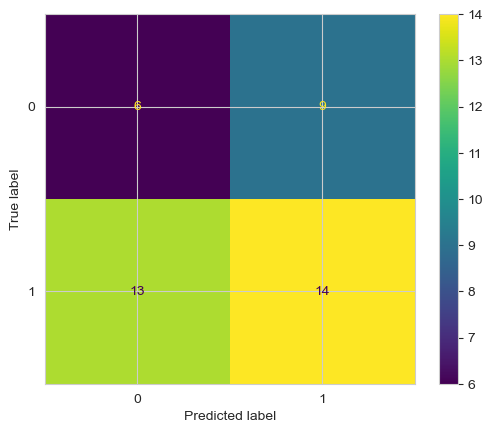

In [108]:
# Data partition for logistic regression:

y1 = hist0['positive']
X1 = hist0_lag.drop(['positive'], axis=1)
y1 = y1.reindex(X1.index)

end_train_index1 = 200
X1_train = X1.iloc[:end_train_index1]
X1_valid = X1.iloc[end_train_index1:]

y1_train = y1.iloc[:end_train_index1]
y1_valid = y1.iloc[end_train_index1:]


# Logistic regression model and fitting:

logreg_model1 = LogisticRegression()
logreg_model1.fit(X1_train,y1_train)


# Model Performance

logreg_pred1 = logreg_model1.predict(X1_valid)
logreg_pred1 = pd.Series(logreg_pred1, index=X1_valid.index)
y1_valid = y1_valid.reindex(logreg_pred1.index)

cm1 = confusion_matrix(y1_valid, logreg_pred1, labels=logreg_model1.classes_)
cmd1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=logreg_model1.classes_)
cmd1.plot()

print(classification_report(y1_valid, logreg_pred1))

#### Recurrent Neutal Network: Simple RNN and Dense  

In [109]:
#!pip install tensorflow

In [110]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [111]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(amzn_train.values.reshape(-1, 1))


In [112]:
# Prepare the data for training
def create_sequences(amzn_train, seq_length):
    sequences = []
    targets = []
    for i in range(len(amzn_train) - seq_length):
        seq = amzn_train[i:i+seq_length]
        target = amzn_train[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10  # You can adjust this parameter based on your needs
X, y = create_sequences(ts_scaled, sequence_length)


In [113]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [117]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1, activation='linear'))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_percentage_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 24984.9609
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 28838.2363
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 62065.0469
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 23179.5488
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 7042.7710
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 5373.7686
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 1631.6072
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 15797.0566
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 12565.3301
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 16259.6133
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 11010.4756
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 26383.0762
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 5856.7358
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 35874.5391
Epoch

In [118]:
# Inverse transform the predictions and actual values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


# Calculate and print the metrics
aes_eval_metricsf = ts_eval_metrics(y_test_inv, y_pred_inv)

Time Series Evaluation Metrics
MSE = 46.321776150714946
MAE = 5.114645911907328
RMSE = 6.806010296107033
MAPE = 0.04358472877813031
r2 = 0.88970492017872



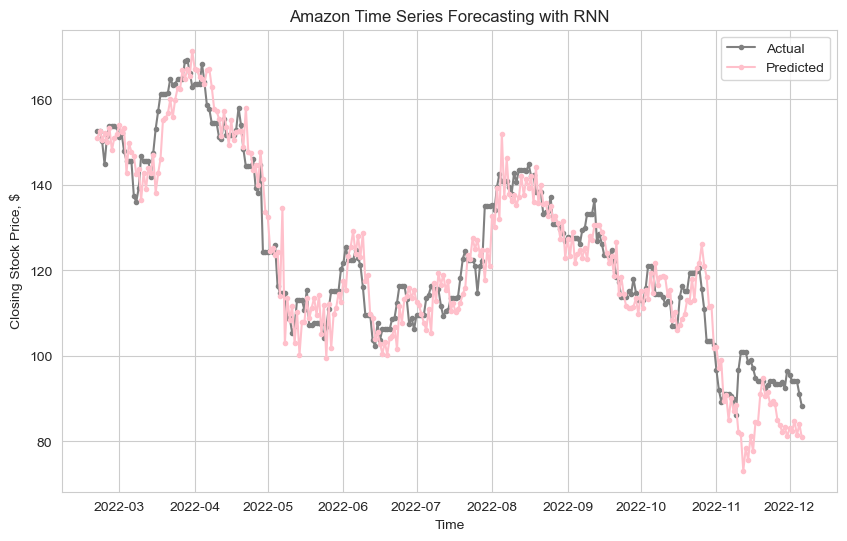

In [119]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(amzn_train.index[train_size + sequence_length:], y_test_inv, label='Actual', marker='.', color = 'gray')
plt.plot(amzn_train.index[train_size + sequence_length:], y_pred_inv, label='Predicted', marker='.', color = 'pink')
plt.title('Amazon Time Series Forecasting with RNN')
plt.xlabel('Time')
plt.ylabel('Closing Stock Price, $')
plt.legend()
plt.show()

# RNN forecast model did really well in predicting the test dataset as shown below. 

###### Code References:

Brownlee J. (2020, April 12). A gentle introduction to exponential smoothing for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

Chaudhari, S. (2021, February 11). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

ritvikmath. (2020, August 27). Seasonal-trend decomposition using LOESS. Github. https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb

Shmueli, G. (2016). ARIMA models [Video]. YouTube. https://youtu.be/0xHf-SJ9Z9U?feature=shared

statsmodels. (2023, May 05). statsmodels.tsa.holtwinters.ExponentialSmoothing. statsmodels.   https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#

TensorFlow. (2023, September 27). tf.keras.Sequential. TensorFlow. 
    https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

University of San Diego. (n.d.). Lab 1.2: Model selection. University of San Diego.   https://sandiego.instructure.com/courses/847/pages/lab-1-dot-2-model-selection?module_item_id=226903 

TensorFlow. (2023, September 27). tf.keras.Sequential. TensorFlow. 
    https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
    